In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Constants

In [3]:
params_to_work_with = constants.ALL_PARAMS
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB', 'H023_IN', 'H061_SE']

Load the data and proccess it

In [4]:
def load_data(data_path, rois, outliers=[]):
    subjects_raw_data = DataProcessor(
        data_path, rois, rois).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, rois, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(
        chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects


def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data

### All of the brain

In [5]:
all_data_all_brain_raw, young_data_all_brain_raw, old_data_all_brain_raw = load_data(
    constants.PATH_TO_ALL_BRAIN_all_params_raw,
    constants.ROI_ALL_BRAIN,
    outliers=outliers)
all_data_all_brain_z_score, young_data_all_brain_z_score, old_data_all_brainz_score = load_data(
    constants.PATH_TO_ALL_BRAIN_all_params_z_score,
    constants.ROI_ALL_BRAIN,
    outliers=outliers)

print(
    f'num young: {young_data_all_brain_raw.subjects.nunique()}, num old: {old_data_all_brain_raw.subjects.nunique()}')

num young: 16, num old: 14


### Cortex and gray subcortex

In [6]:
all_data_cortex_and_g_subcortex_raw, young_data_cortex_and_g_subcortex_raw, old_data_cortex_and_g_subcortex_raw = load_data(
    constants.PATH_TO_CORTEX_AND_GRAY_SUB_CORTEX_all_params_raw,
    constants.ROI_CORTEX_AND_GRAY_SUB_CORTEX,
    outliers=outliers)
all_data_cortex_and_g_subcortex_z_score, young_data_cortex_and_g_subcortex_z_score, old_data_cortex_and_g_subcortex_z_score = load_data(
    constants.PATH_TO_CORTEX_AND_GRAY_SUB_CORTEX_all_params_z_score,
    constants.ROI_CORTEX_AND_GRAY_SUB_CORTEX,
    outliers=outliers)

print(
    f'num young: {young_data_cortex_and_g_subcortex_raw.subjects.nunique()}, num old: {old_data_cortex_and_g_subcortex_raw.subjects.nunique()}')

num young: 16, num old: 14


### Cortex

In [7]:
all_data_cortex_raw, young_data_cortex_raw, old_data_cortex_raw = load_data(
    constants.PATH_TO_CORTEX_all_params_raw,
    constants.ROI_CORTEX,
    outliers=outliers)
all_data_cortex_z_score, young_data_cortex_z_score, old_data_cortex_z_score = load_data(
    constants.PATH_TO_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=outliers)

print(
    f'num young: {young_data_cortex_raw.subjects.nunique()}, num old: {old_data_cortex_raw.subjects.nunique()}')

num young: 16, num old: 14


### WM subcortex

In [8]:
all_data_wm_subcortex_raw, young_data_wm_subcortex_raw, old_data_wm_subcortex_raw = load_data(
    constants.PATH_TO_WM_SUBCORTEX_all_params_raw,
    constants.ROI_WM,
    outliers=outliers)
all_data_wm_subcortex_z_score, young_data_wm_subcortex_z_score, old_data_wm_subcortex_z_score = load_data(
    constants.PATH_TO_WM_SUBCORTEX_all_params_z_score, 
    constants.ROI_WM,
    outliers=outliers)

print(
    f'num young: {young_data_wm_subcortex_raw.subjects.nunique()}, num old: {old_data_wm_subcortex_raw.subjects.nunique()}')

num young: 16, num old: 14


### Gray subcortex

In [9]:
all_data_g_subcortex_raw, young_data_g_subcortex_raw, old_data_g_subcortex_raw = load_data(
    constants.PATH_TO_SUB_CORTEX_all_params_raw,
    constants.ROI_SUBCORTEX,
    outliers=outliers)
all_data_g_subcortex_z_score, young_data_g_subcortex_z_score, old_data_g_subcortex_z_score = load_data(
    constants.PATH_TO_SUB_CORTEX_all_params_z_score, 
    constants.ROI_SUBCORTEX,
    outliers=outliers)

print(
    f'num young: {young_data_g_subcortex_raw.subjects.nunique()}, num old: {old_data_g_subcortex_raw.subjects.nunique()}')

num young: 16, num old: 14


## Raw data analysis 

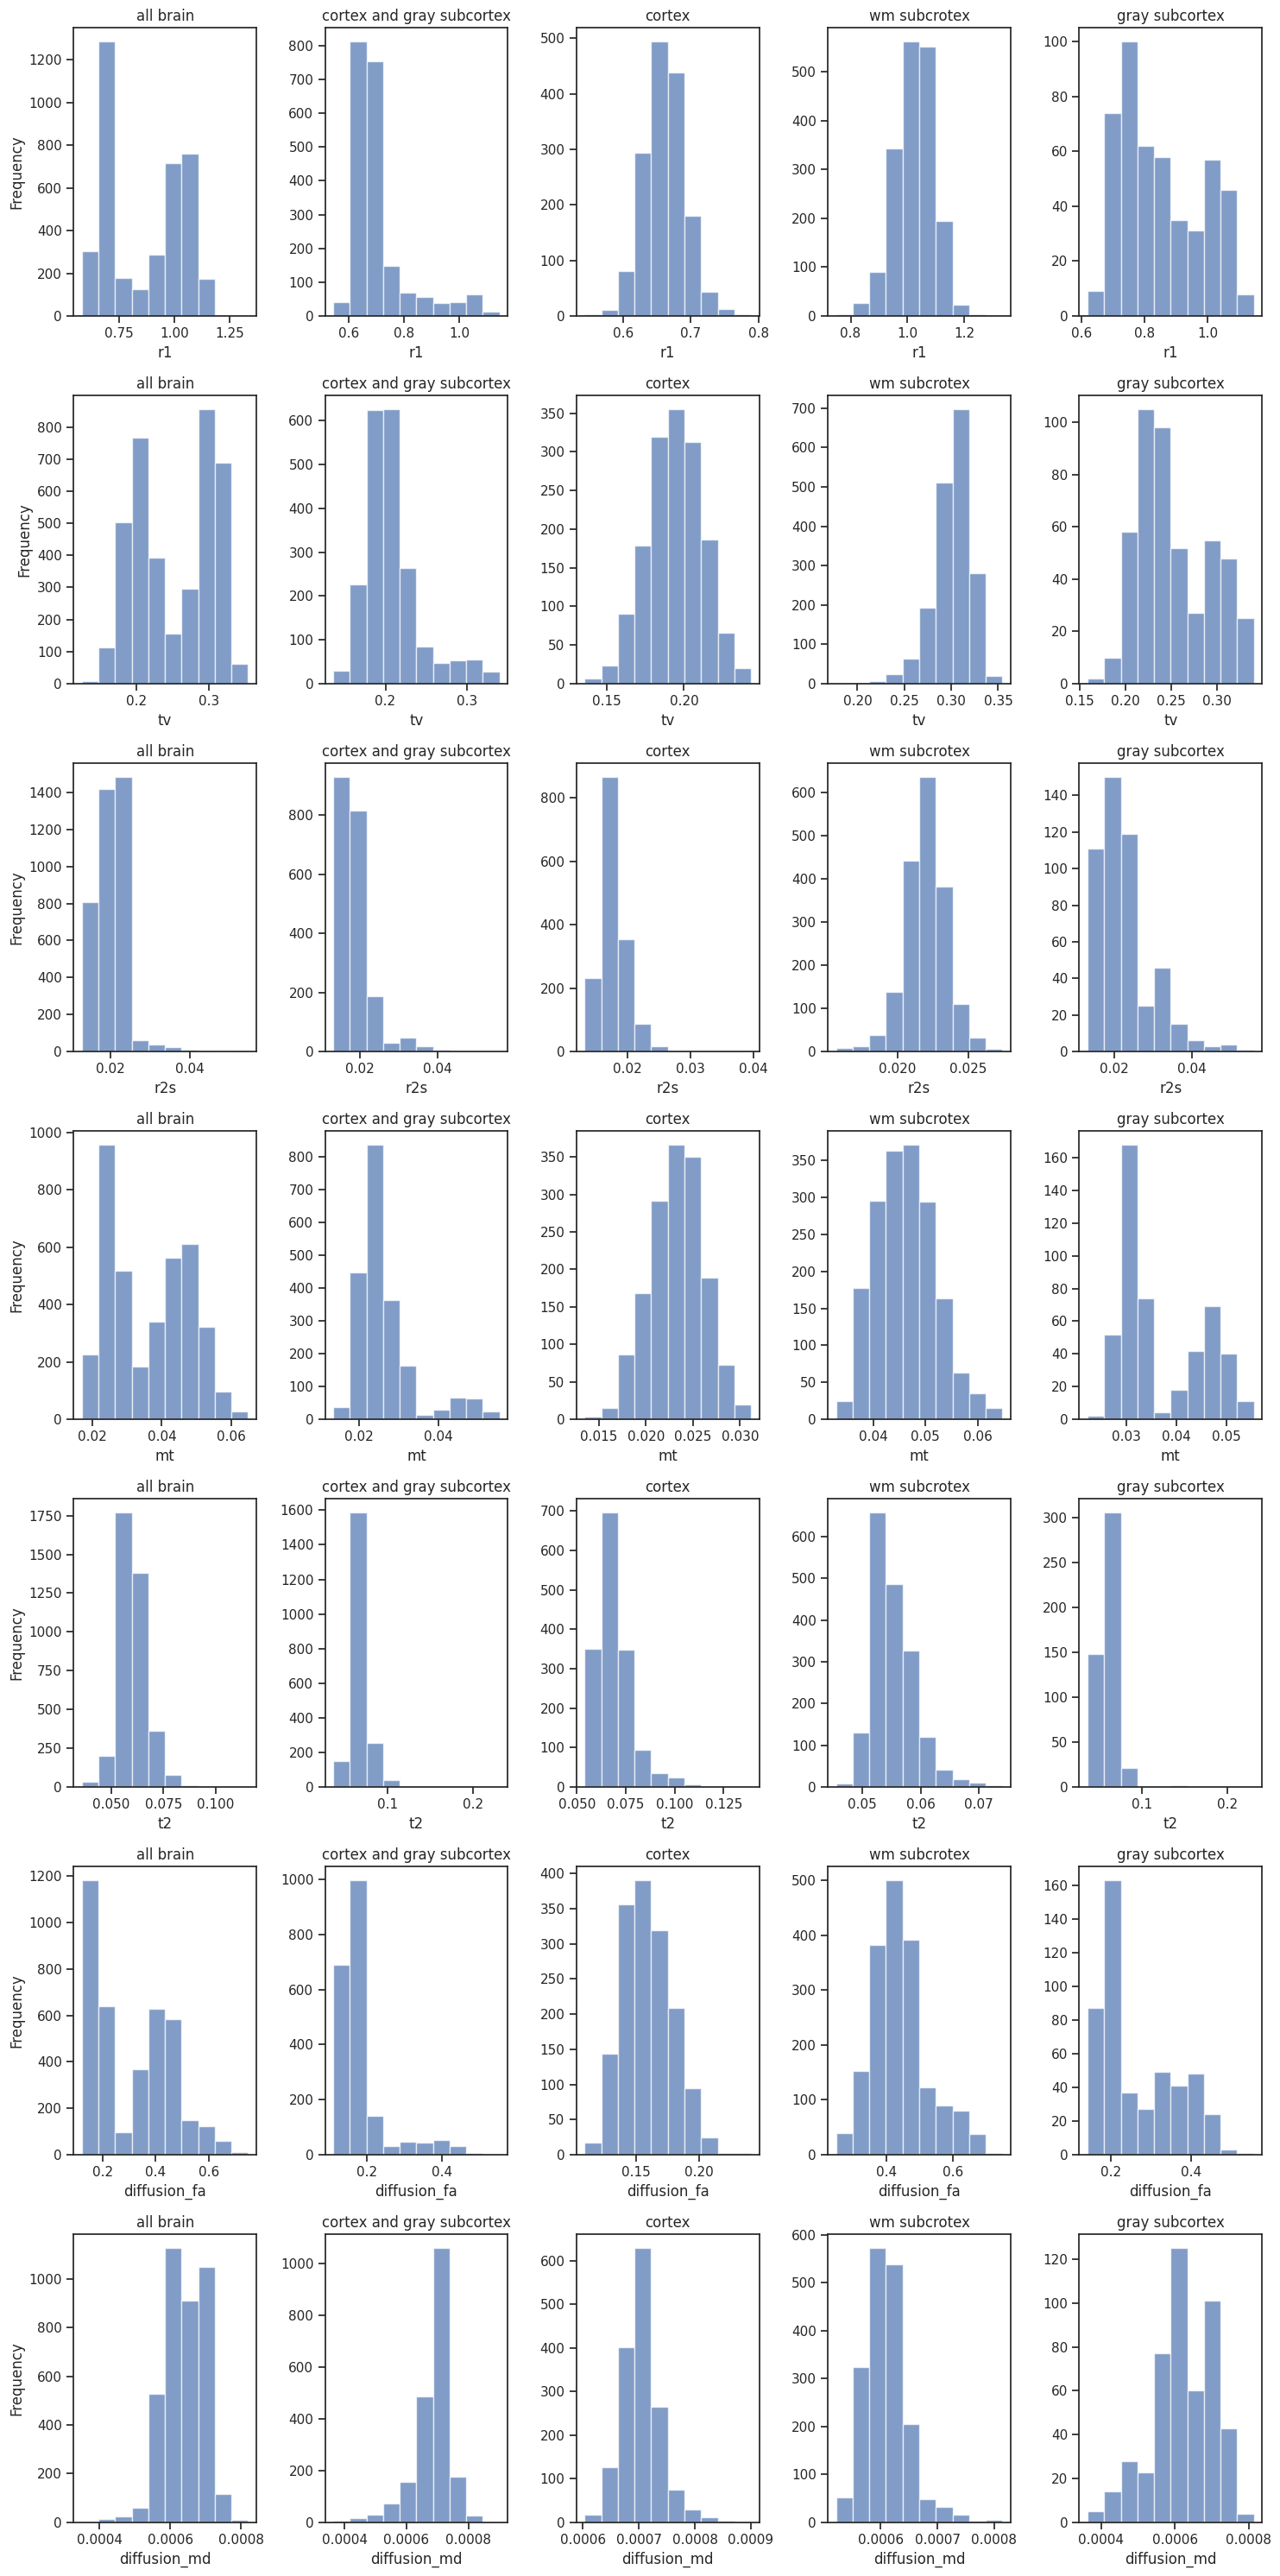

In [10]:
fig, ax = plt.subplots(nrows=7, ncols=5, figsize=(15, 30))

for i, param in enumerate(params_to_work_with):
    for j, (dataset, label) in enumerate(zip([all_data_all_brain_raw, all_data_cortex_and_g_subcortex_raw,
                                               all_data_cortex_raw, all_data_wm_subcortex_raw, all_data_g_subcortex_raw],
                                              ['all brain', 'cortex and gray subcortex', 'cortex', 'wm subcrotex', 'gray subcortex'])):
        # ax[i, j].set_title(f'{param} hist - {label}')
        ax[i, j].set_title(label)
        ax[i, j].hist(dataset[param], alpha=0.7)
        ax[i, j].set_xlabel(param)
        if j == 0:  # Set y-label for the first column in each row
            ax[i, j].set_ylabel('Frequency') 

plt.tight_layout()  # Adjust layout to fit the y-label


### Check seperate normalization 

In [11]:
chosen_data_z_score = pd.concat([all_data_cortex_z_score, all_data_g_subcortex_z_score, all_data_wm_subcortex_z_score])
young_data_z_score = pd.concat([young_data_cortex_z_score, young_data_g_subcortex_z_score, young_data_wm_subcortex_z_score])
old_data_z_score = pd.concat([old_data_cortex_z_score, old_data_g_subcortex_z_score, old_data_wm_subcortex_z_score])

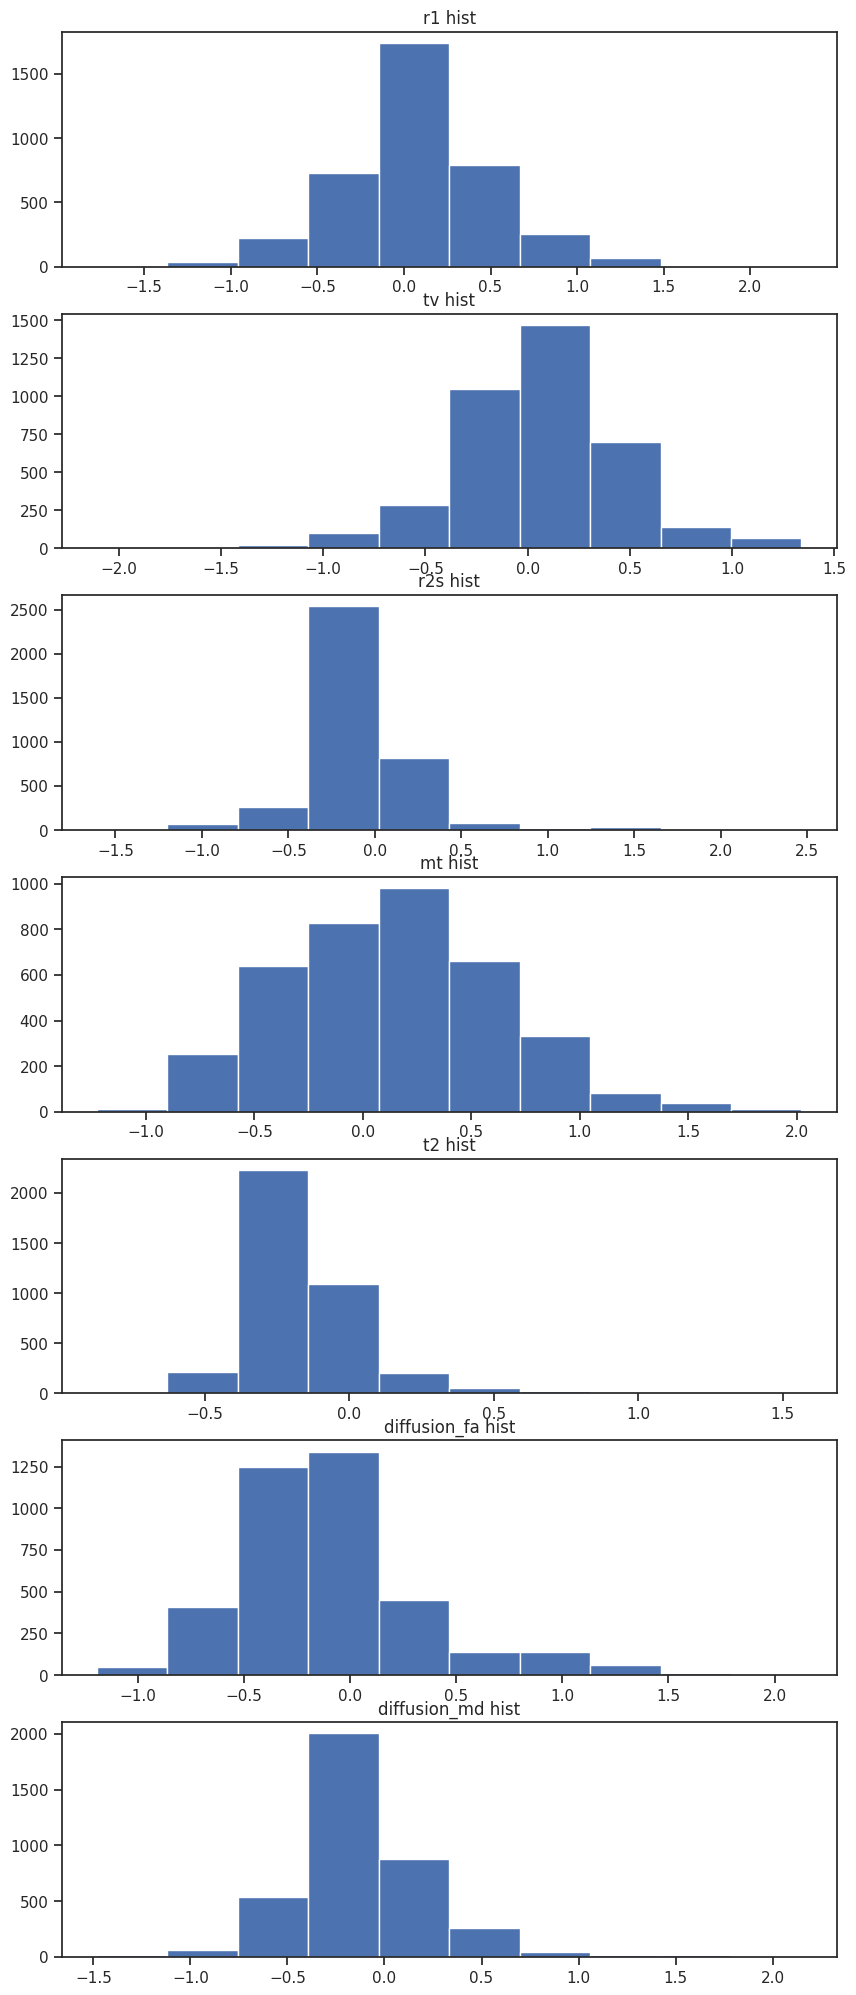

In [12]:
fig, ax = plt.subplots(len(params_to_work_with), 1, figsize=(10, 25))

for i, param in enumerate(params_to_work_with):
    ax[i].set_title(f'{param} hist')
    ax[i].hist(chosen_data_z_score[param])

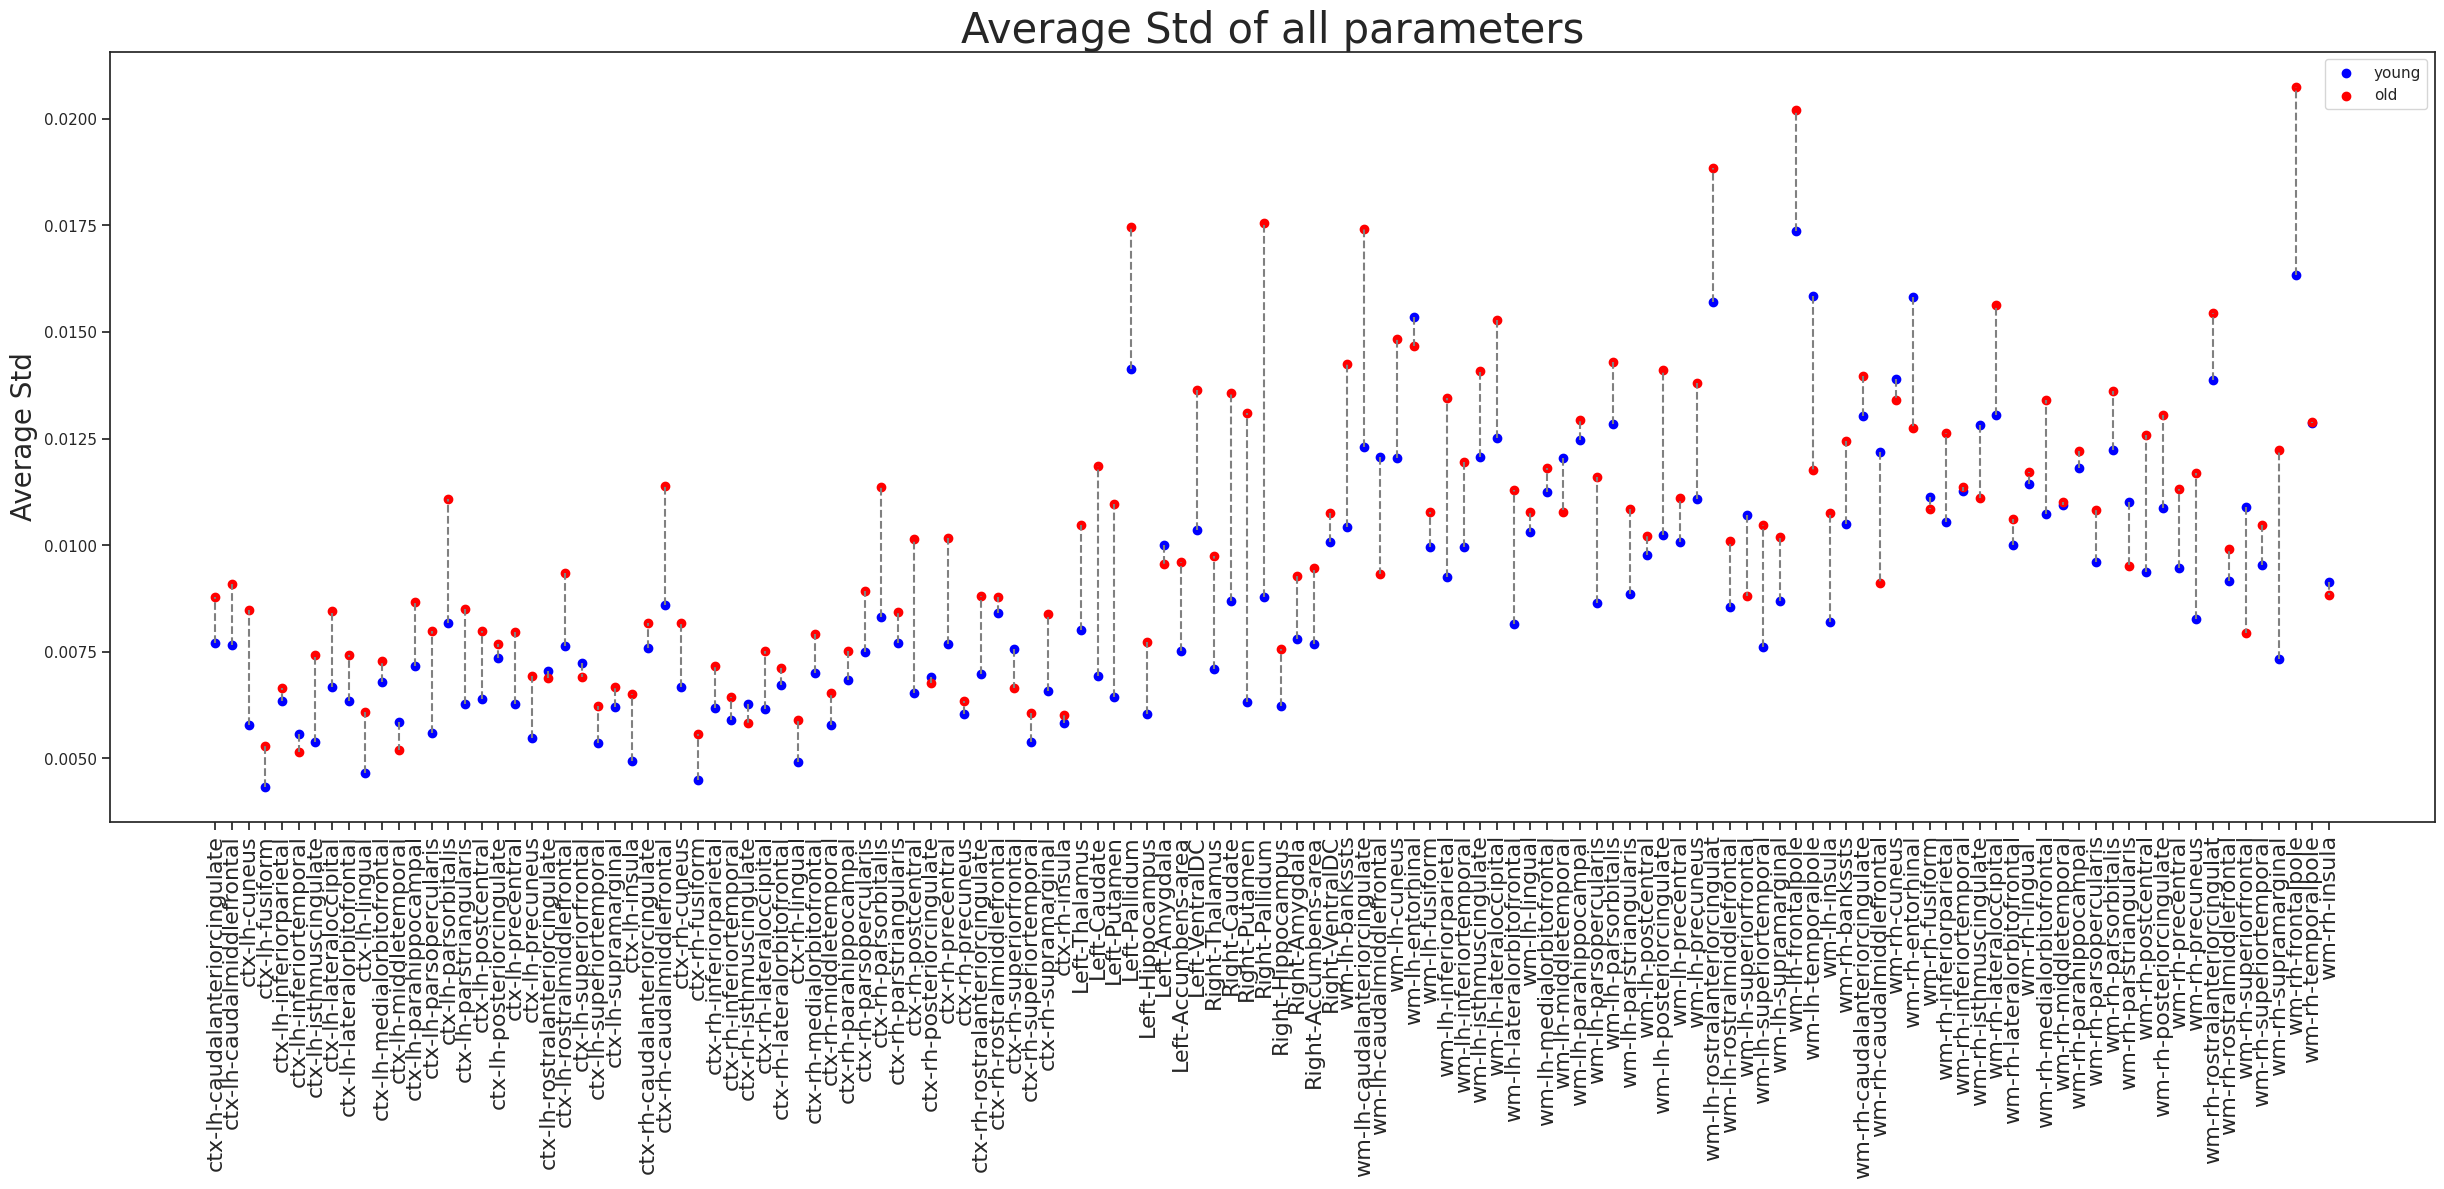

In [13]:
%autoreload 2
data_groups = [(young_data_all_brain_raw, 'blue', 'young'), (old_data_all_brain_raw, 'red', 'old')]
StatisticsWrapper.calculate_mean_std_for_rois(data_groups, constants.ROI_ALL_BRAIN.values(), params_to_work_with, fig_size=(30, 10))

Mean

In [46]:
%autoreload 2
rois = [('ctx-rh-parstriangularis', 'ctx-rh-caudalanteriorcingulate'), ("wm-rh-parstriangularis", "wm-rh-caudalanteriorcingulate")]

data_groups = [young_data_z_score, old_data_z_score]
colors = ['red', 'blue']

for roi_pair in rois:
    StatisticsWrapper.show_rois_differences_in_polar(data_groups, [roi_pair[0], roi_pair[1]], 
                                                     params_to_work_with, ('young mean', 'old mean'), colors, method='mean')
    
    StatisticsWrapper.show_rois_differences_in_polar(data_groups, [roi_pair[1]], 
                                                        params_to_work_with, (roi_pair[1], roi_pair[1]), colors, method='mean')

std

## Check correlations on the normalized data

In [15]:
def show_correlations_stats(all_data, young_data, old_data, method, linkage_method, divide=False):
    ordered_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, linkage_method,
                                                             title="all")['dendrogram_data']['ivl']
    young_clusters = StatisticsWrapper.hierarchical_clustering(young_data, params_to_work_with, linkage_method,
                                                             title="young")
    old_clusters = StatisticsWrapper.hierarchical_clustering(old_data, params_to_work_with, linkage_method,
                                                             title="old")
    if divide:
        ordered_rois = sorted(ordered_rois, key=custom_sort_key)
        young_result = correlations_by_sub_systems(
            young_data, ordered_rois, method, 'young', show=False)
        old_result = correlations_by_sub_systems(
            old_data, ordered_rois, method, 'old', show=False)

        PlotsManager.plot_heatmap(
            young_result, 'Correlations of young group, divided by neuroanatomical regions', project_name=None)
        PlotsManager.plot_heatmap(
            old_result, 'Correlations of old group, divided by neuroanatomical regions', project_name=None)
        
        cluster_by_subsystem(young_data, old_data, linkage_method)
    else:
        young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, ordered_rois,
                                                          group_title='Correlations of young group', method=method)
        old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, ordered_rois,
                                                        group_title='Correlations of old group', method=method)

    PlotsManager.plot_heatmap(
        old_result - young_result, 'differences of old and young', project_name=None)

    young_corr_means, old_corr_means = show_corr_mean(
        young_result, old_result, ordered_rois, f"ROI average correlations {'for each neuroanatomical region' if divide else ''}", divide)

    return young_clusters, old_clusters

def show_corr_mean(young_result, old_result, ordered_rois, title, divide=False):
    np.fill_diagonal(young_result.values, 0)
    np.fill_diagonal(old_result.values, 0)
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1)

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}', fontsize=30)
    ax.scatter(ordered_rois, young_result['corr_mean'].to_numpy(
    ), color='purple', s=15, alpha=0.8, label='young')
    ax.scatter(ordered_rois, old_result['corr_mean'].to_numpy(
    ), color='olive', s=15, alpha=0.8, label='old')

    if divide:
        add_dividers(ax)      
        ax.set_xticks([])
    else:
        ax.set_xticks(ordered_rois)
        ax.set_xticklabels(ordered_rois, rotation='vertical', fontsize=12)

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(ordered_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='dotted')

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(fontsize=16, loc="upper right")

    return young_result['corr_mean'], old_result['corr_mean']


def show_distances(method, params_to_work_with, all_data, young_subjects, old_subjects, title):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(
        all_data, params_to_work_with, 'single', title="all")['dendrogram_data']['ivl']
    young_distances = StatisticsWrapper.roi_distances(
        young_subjects, params_to_work_with, clusters_rois, method=method, title=f'Young rois {title}')
    old_distances = StatisticsWrapper.roi_distances(
        old_subjects, params_to_work_with, clusters_rois, method=method, title=f'Old rois {title}')

    _, __ = show_corr_mean(young_distances, old_distances,
                           clusters_rois, f'Average ROIS {title}')


def custom_sort_key(s):
    if s.startswith('ctx'):
        return (0, s)  # First priority
    elif s.startswith('wm'):
        return (1, s)  # Second priority
    else:
        return (2, s)  # Third priority


def divide_rois(ordered_rois, custom_sort_key):
    wm_group = []
    ctx_group = []
    other_group = []

    for roi in ordered_rois:
        key = custom_sort_key(roi)
        if key[0] == 0:
            ctx_group.append(roi)
        elif key[0] == 1:
            wm_group.append(roi)
        else:
            other_group.append(roi)

    return wm_group, ctx_group, other_group


def correlations_by_sub_systems(data, ordered_rois, method, group_name, show):
    # Divide ROIs into subgroups
    wm_rois, ctx_rois, sub_gray_rois = divide_rois(
        ordered_rois, custom_sort_key)

    # Initialize lists to store results
    results = []

    # Perform correlation analysis for each subgroup
    for subgroup in [ctx_rois, wm_rois, sub_gray_rois]:
        result = StatisticsWrapper.roi_correlations(data[data['ROI_name'].isin(subgroup)], params_to_work_with, subgroup,
                                                    group_title=f'Correlations of {group_name} group', method=method, show=show)
        results.append(result)

    # Concatenate the results
    return pd.concat(results)

def add_dividers(ax: plt.Axes):
    ctx_values = {"name": 'ctx', "start": -1, "end": len(constants.ROI_CORTEX) - 0.3, "color": 'green'}
    wm_values = {"name": 'wm', "start": len(constants.ROI_CORTEX) -0.3, "end": len(constants.ROI_CORTEX) + len(constants.ROI_WM) - 0.3, "color": 'yellow'}
    sub_g_values = {"name": 'sub_ctx', "start": len(constants.ROI_CORTEX) + len(constants.ROI_WM) -0.3,
                     "end": len(constants.ROI_CORTEX) + len(constants.ROI_WM) + len(constants.ROI_SUBCORTEX) + 1, "color": 'pink'}
    divide_values = [ctx_values, wm_values, sub_g_values]
    
    for divide_value in divide_values:
        ax.axvline(divide_value['end'], alpha=0.5, linestyle='--', linewidth=2)
        ax.text((divide_value['start'] + divide_value['end']) / 2, -0.4, divide_value['name'], ha='center', va='center', fontsize=15)    

def check_groups_intersection(group1, group2):
    set1 = set(group1)
    set2 = set(group2)
    intersection = set1.intersection(set2)
    num_same_strings = len(intersection)
    print(f'length set1 :{len(set1)}. length set2: {len(set2)}, intersection: {num_same_strings}')

def cluster_by_subsystem(young_data, old_data, linkage_method):
    rois_groups = [constants.ROI_CORTEX, constants.ROI_WM]
    
    for roi_group in rois_groups:
        young_data_subsystem = young_data[young_data['ROI'].isin(roi_group)]
        old_data_subsystem = old_data[old_data['ROI'].isin(roi_group)]

        young_clusters = StatisticsWrapper.hierarchical_clustering(young_data_subsystem, params_to_work_with, linkage_method,
                                                                title="young")
        old_clusters = StatisticsWrapper.hierarchical_clustering(old_data_subsystem, params_to_work_with, linkage_method,
                                                                title="old")


## Gray cortex, gray sub cortex, white sub cortex 

### Check correlations of the entire regions with each other

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



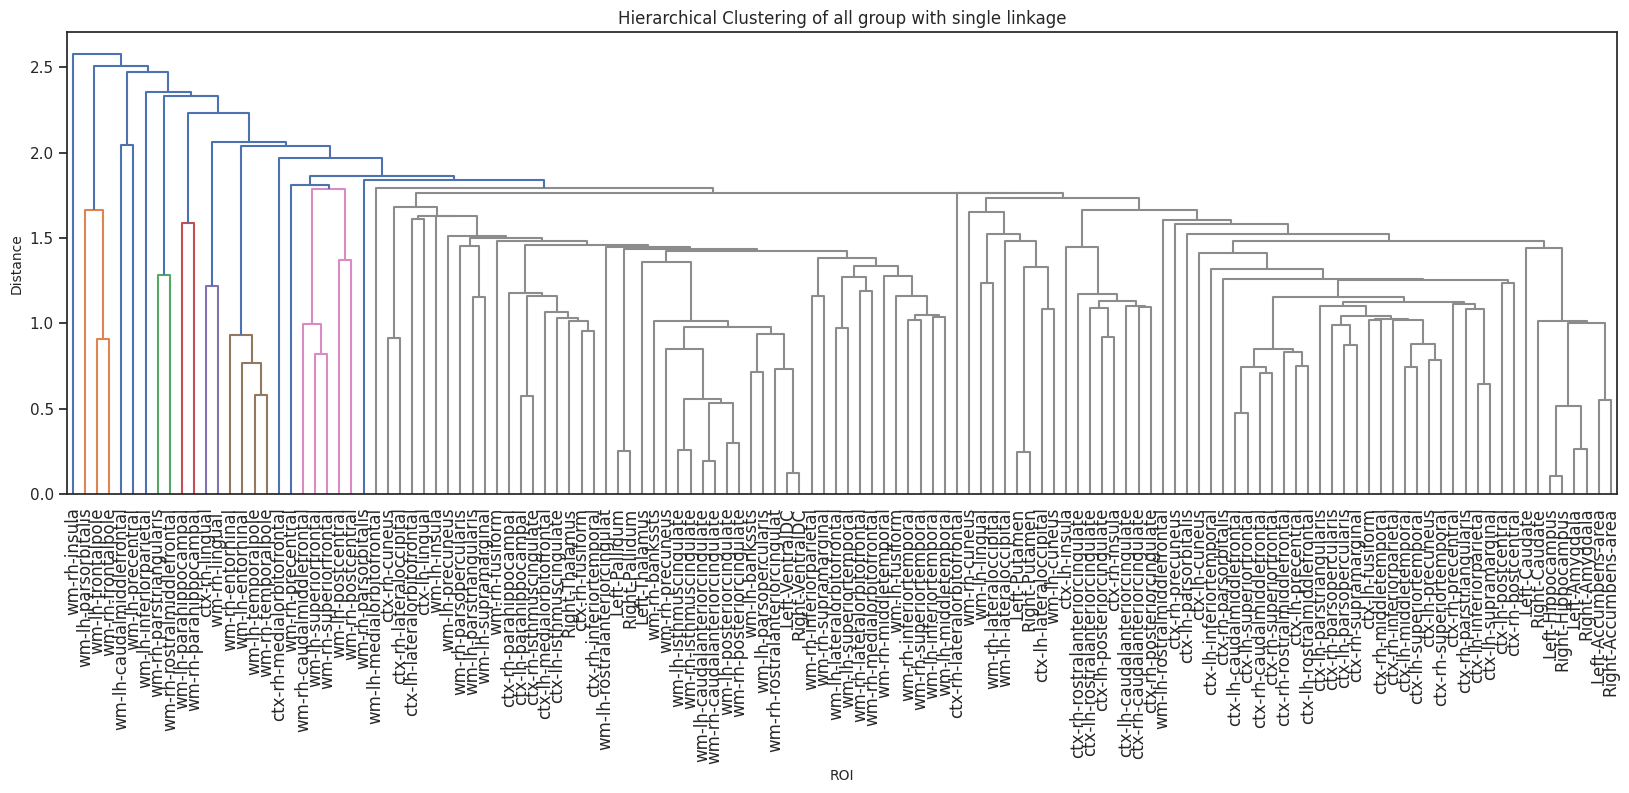

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



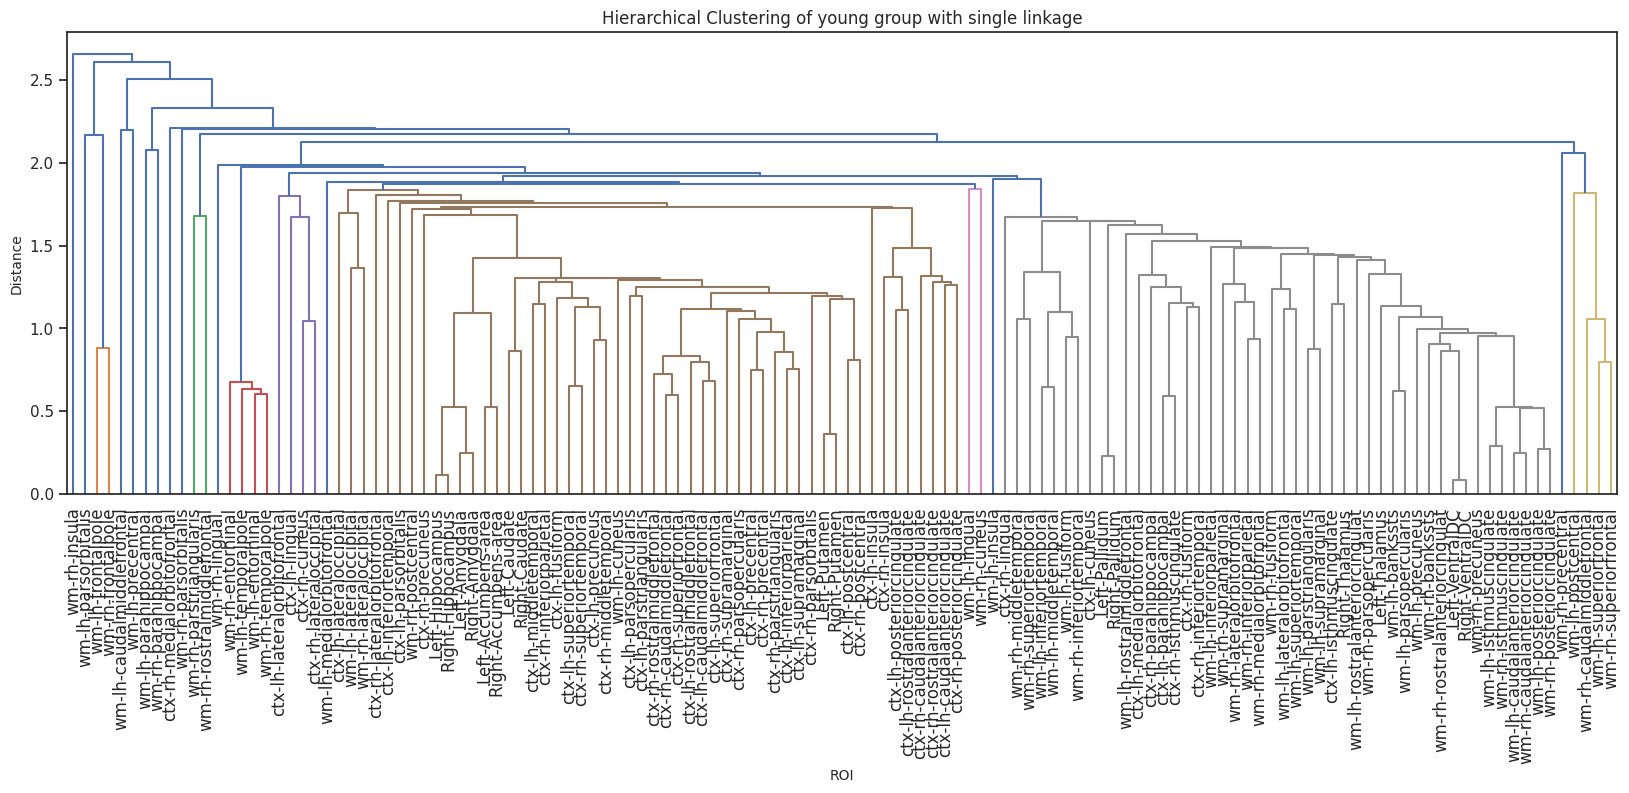

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



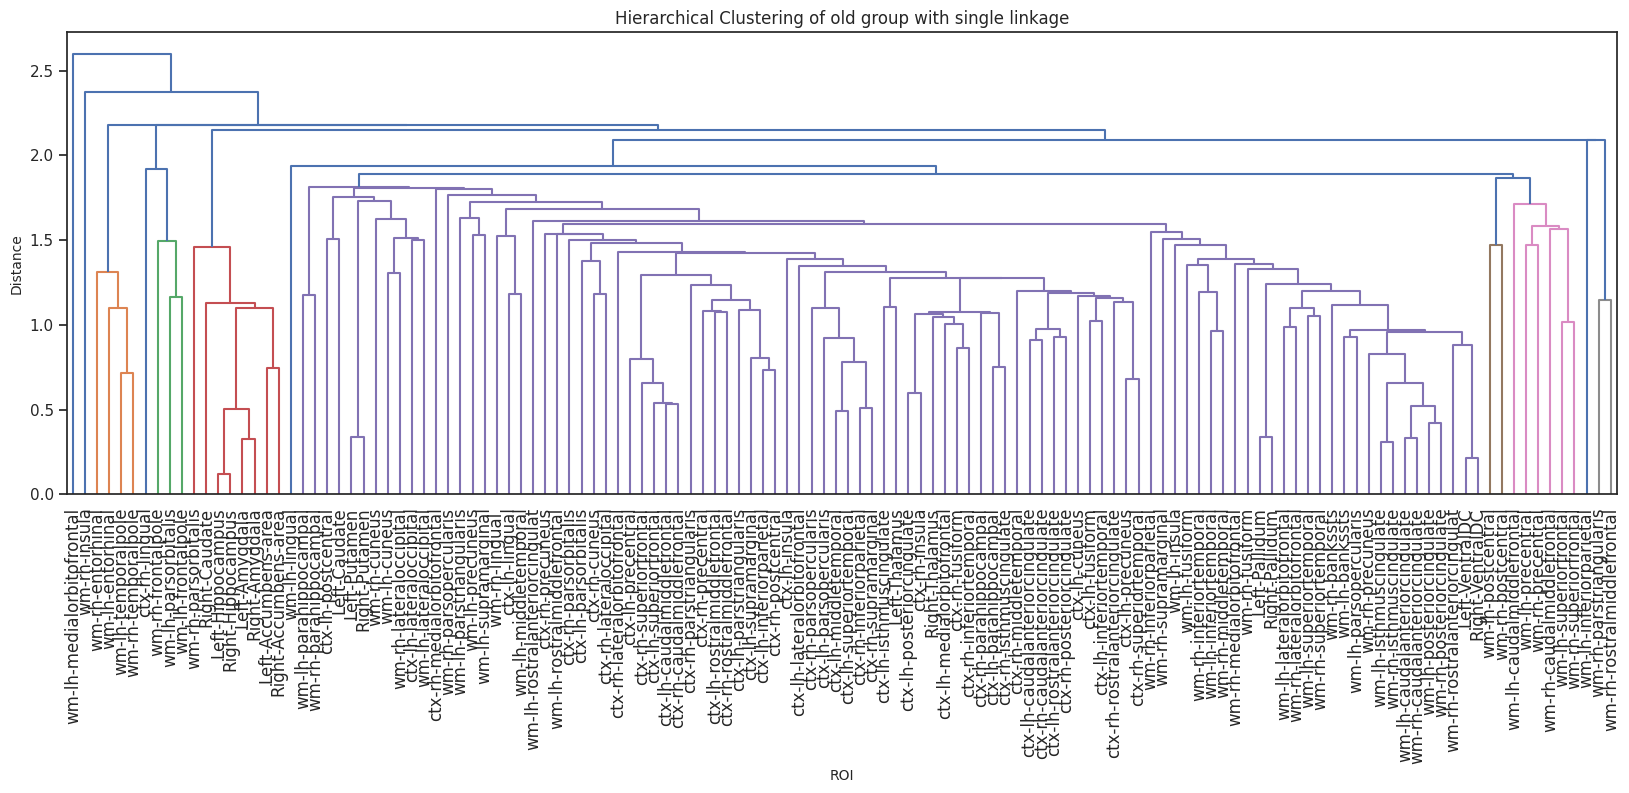

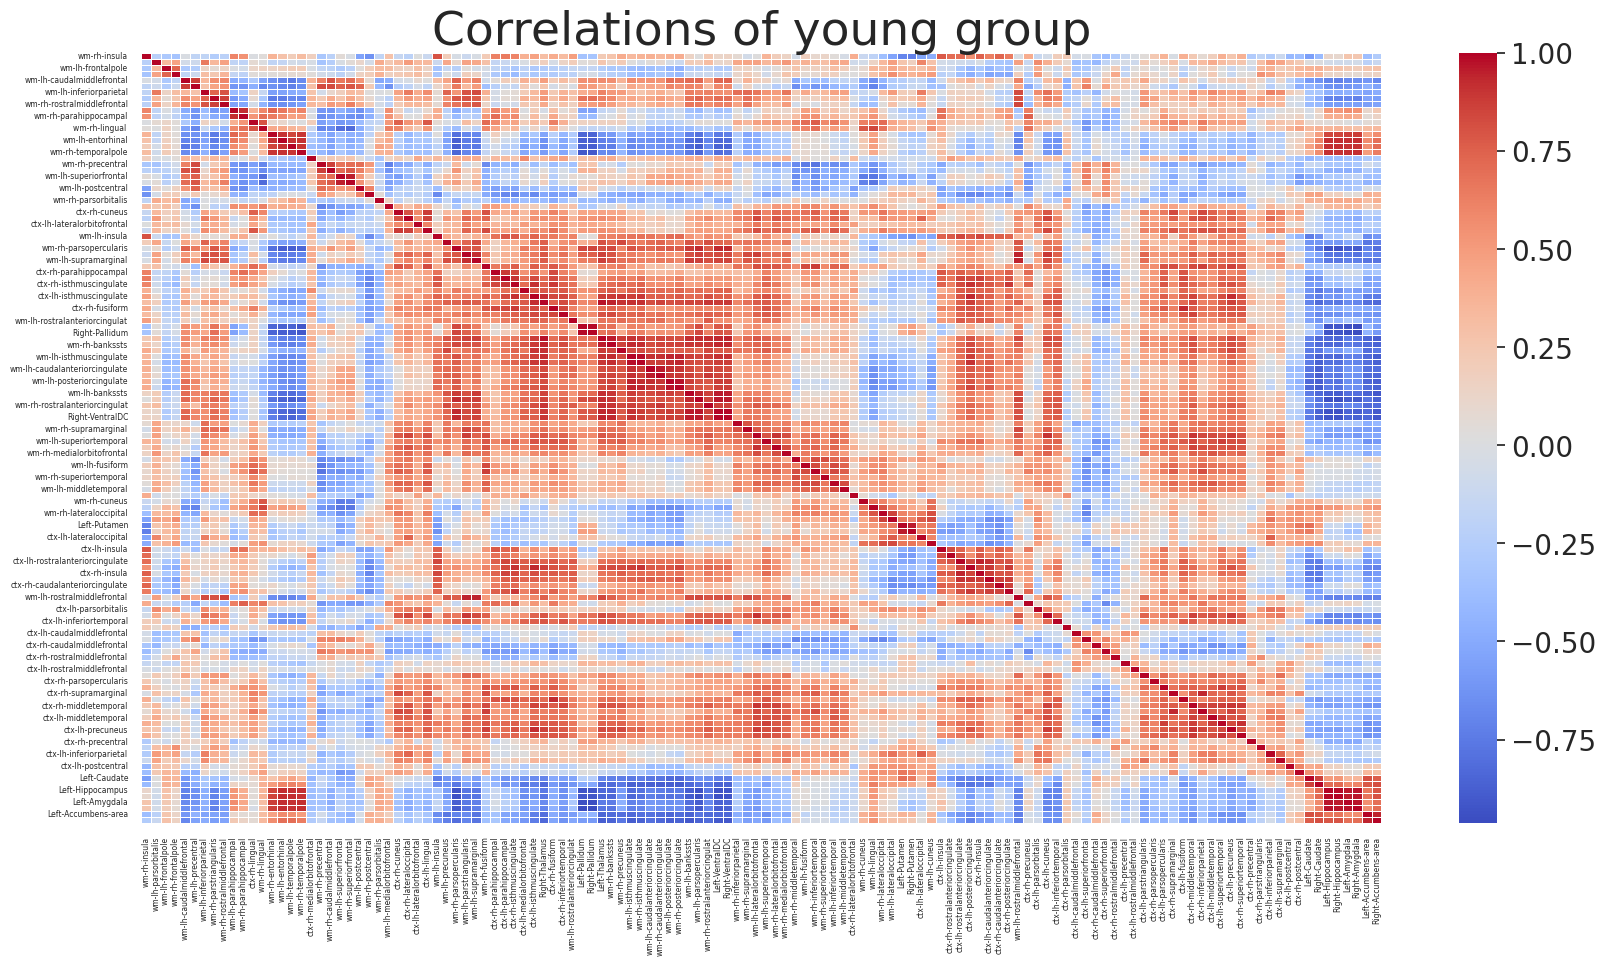

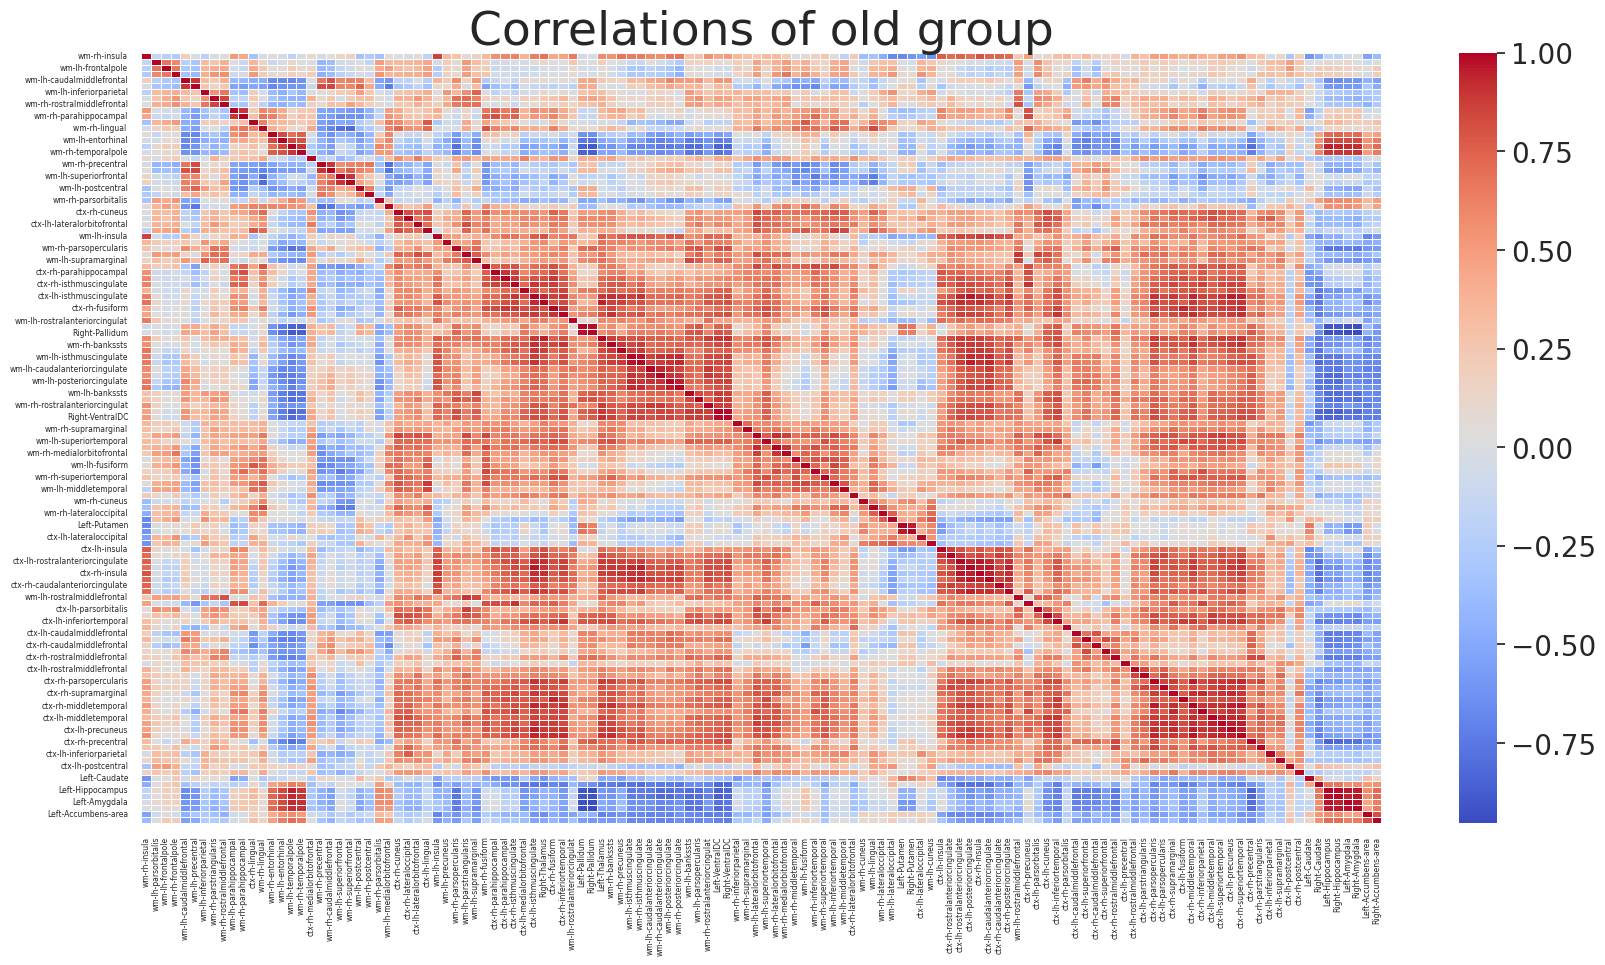

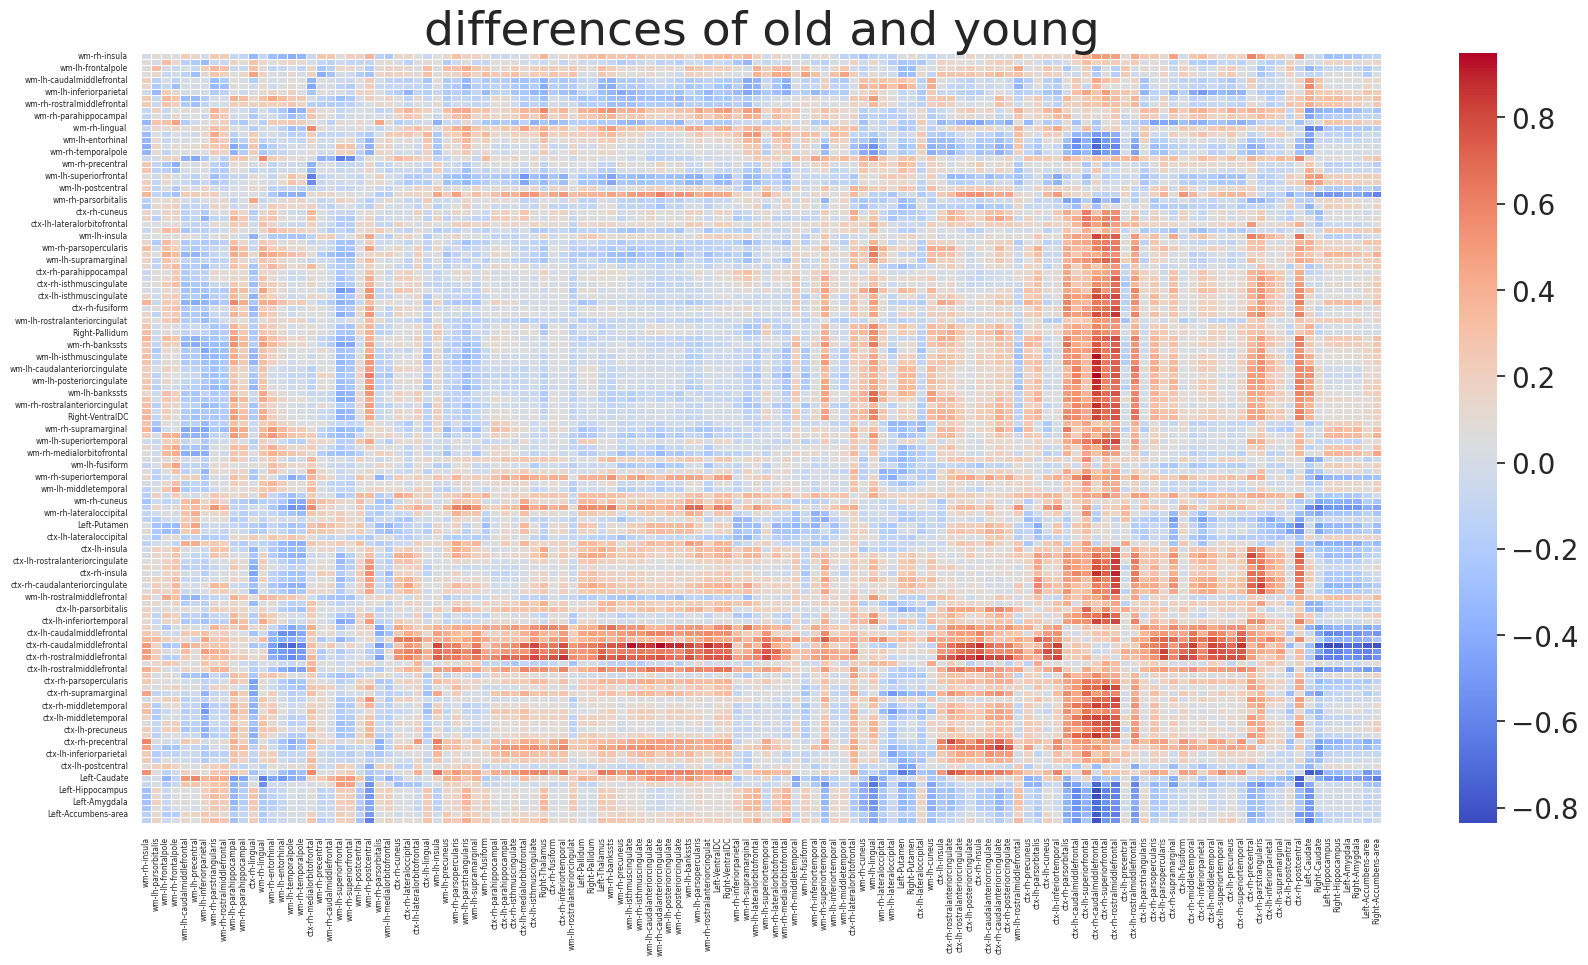

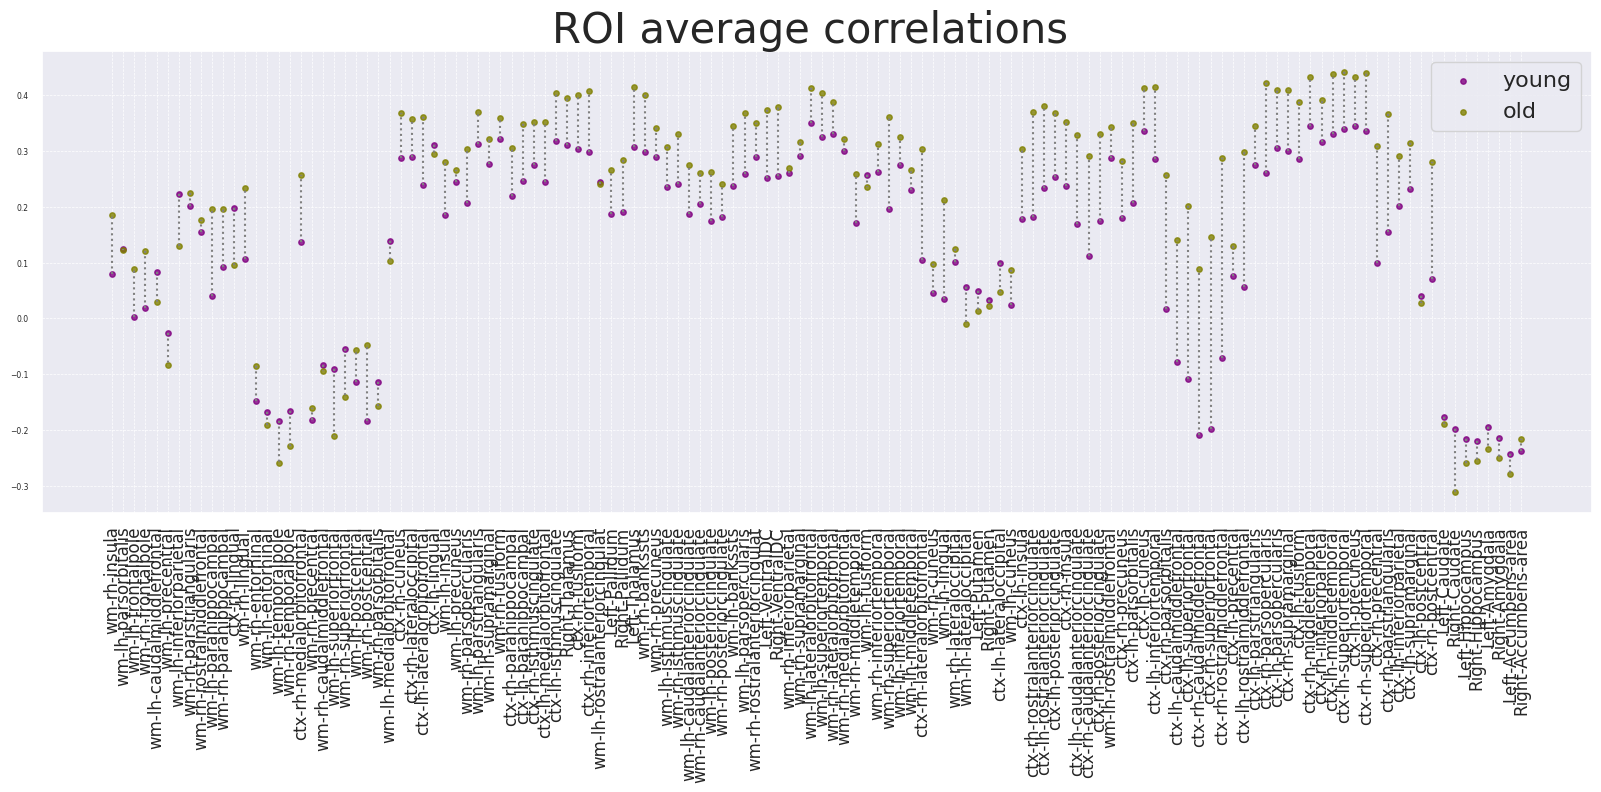

In [16]:
%autoreload 2
young_clusters, old_clusters = show_correlations_stats(chosen_data_z_score, young_data_z_score, old_data_z_score, 'pearson', linkage_method='single')

Check correlations of each neuroanatomical region by itself

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



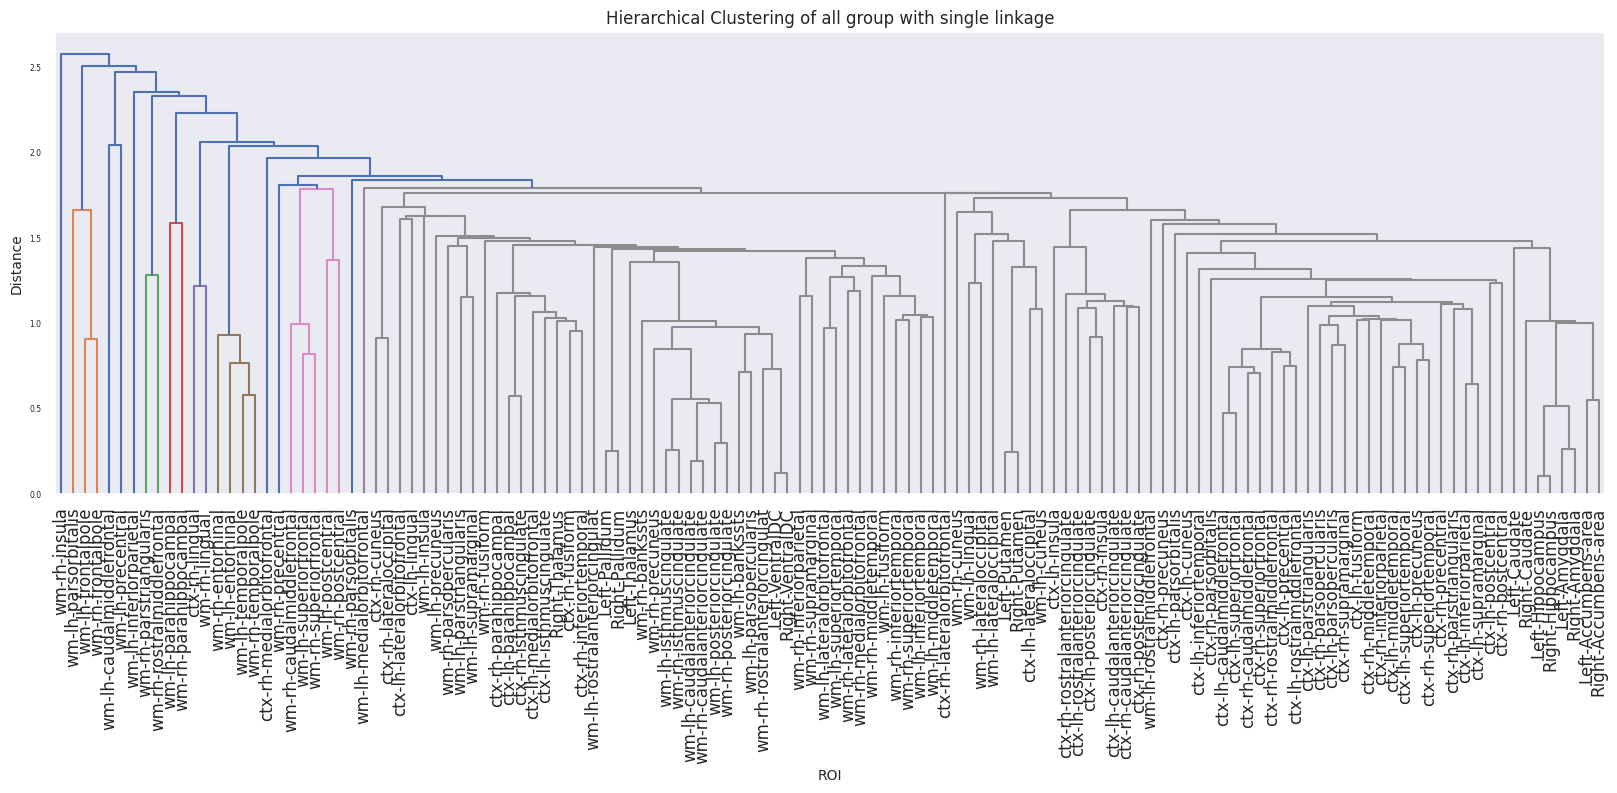

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



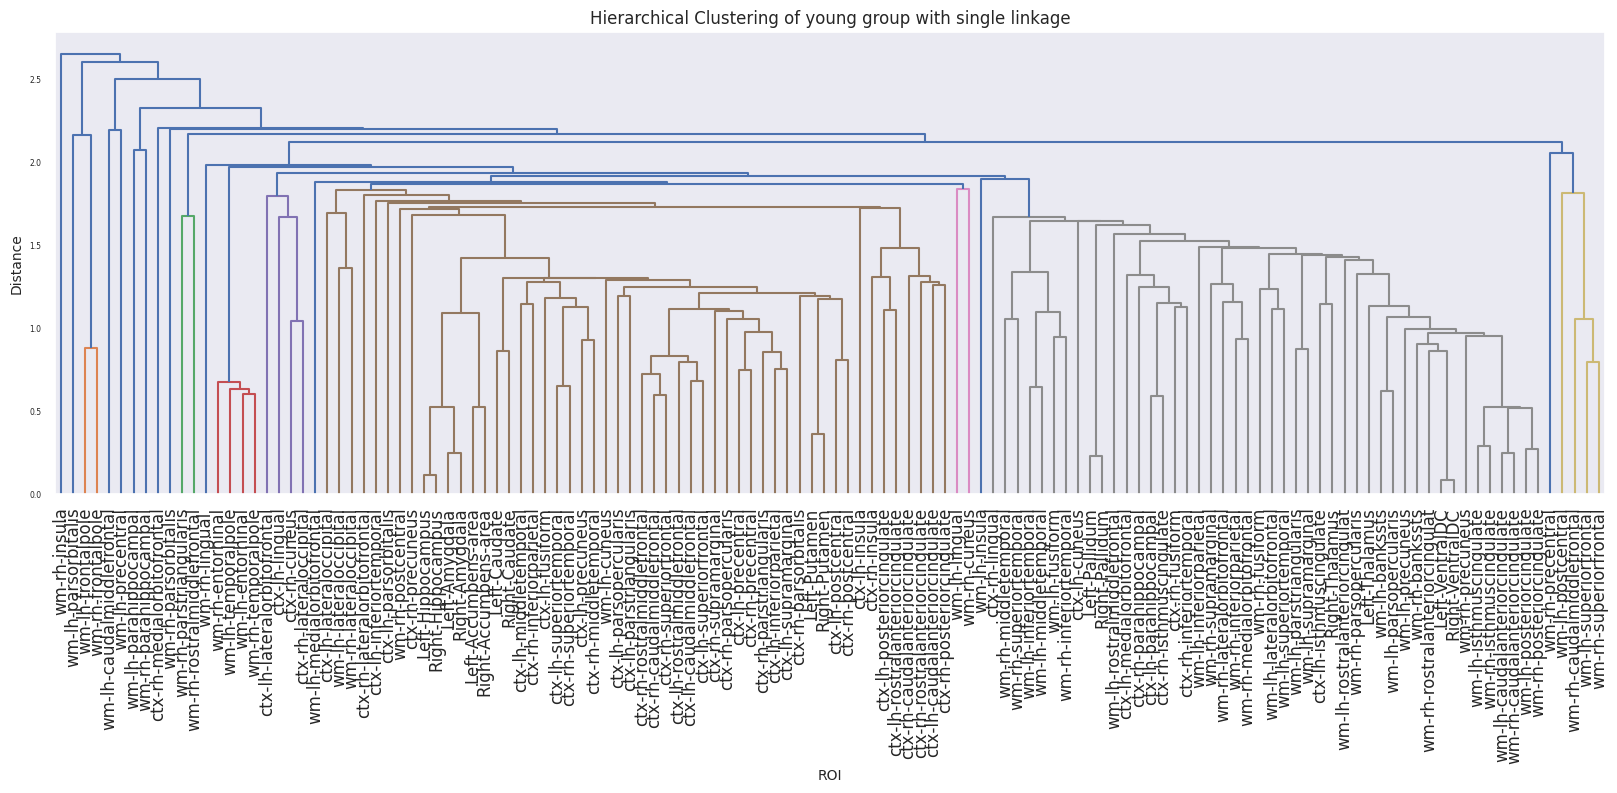

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



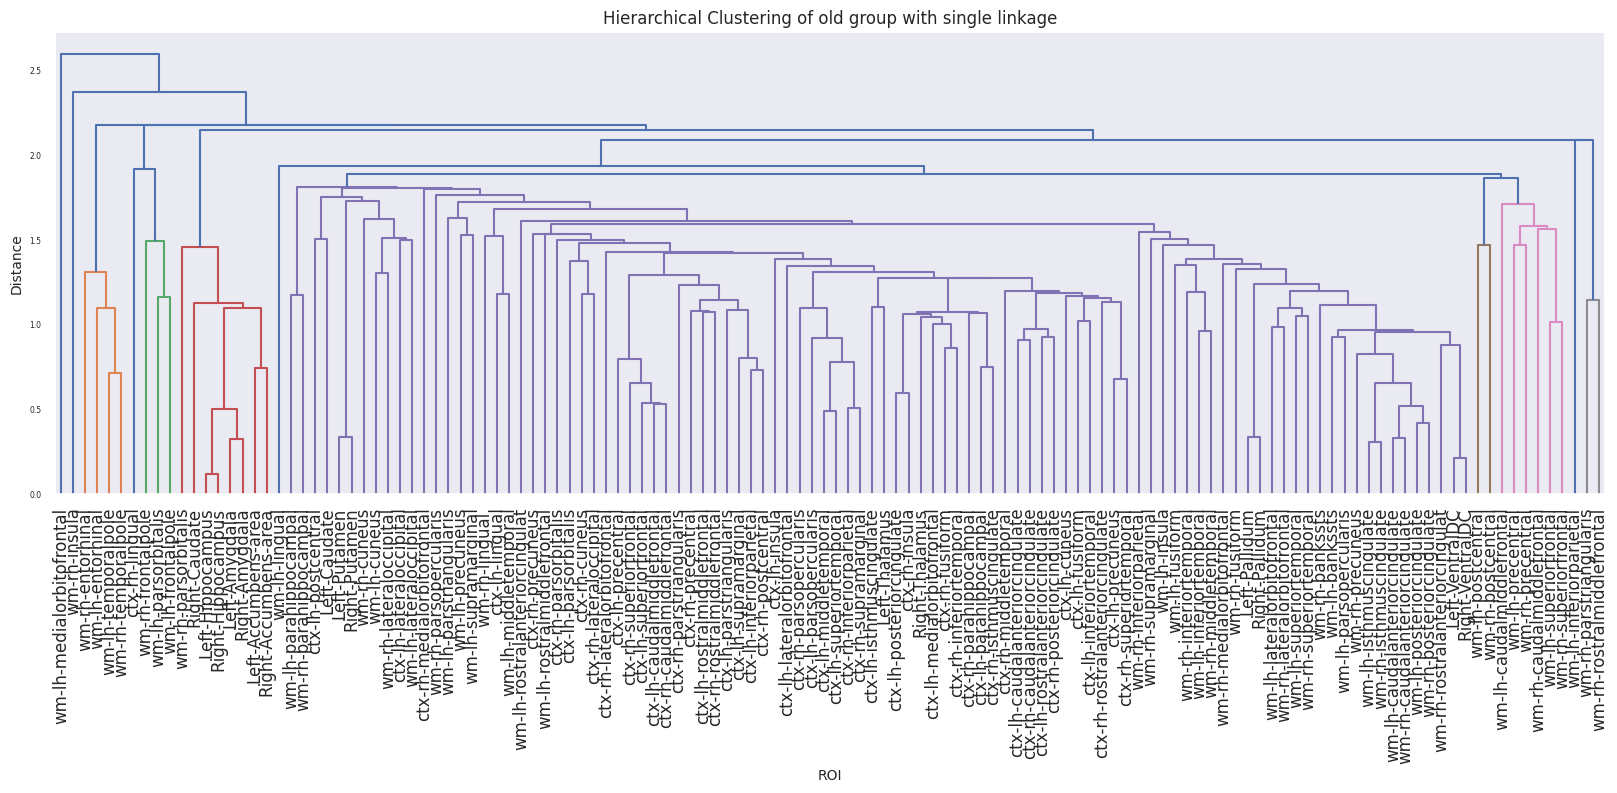

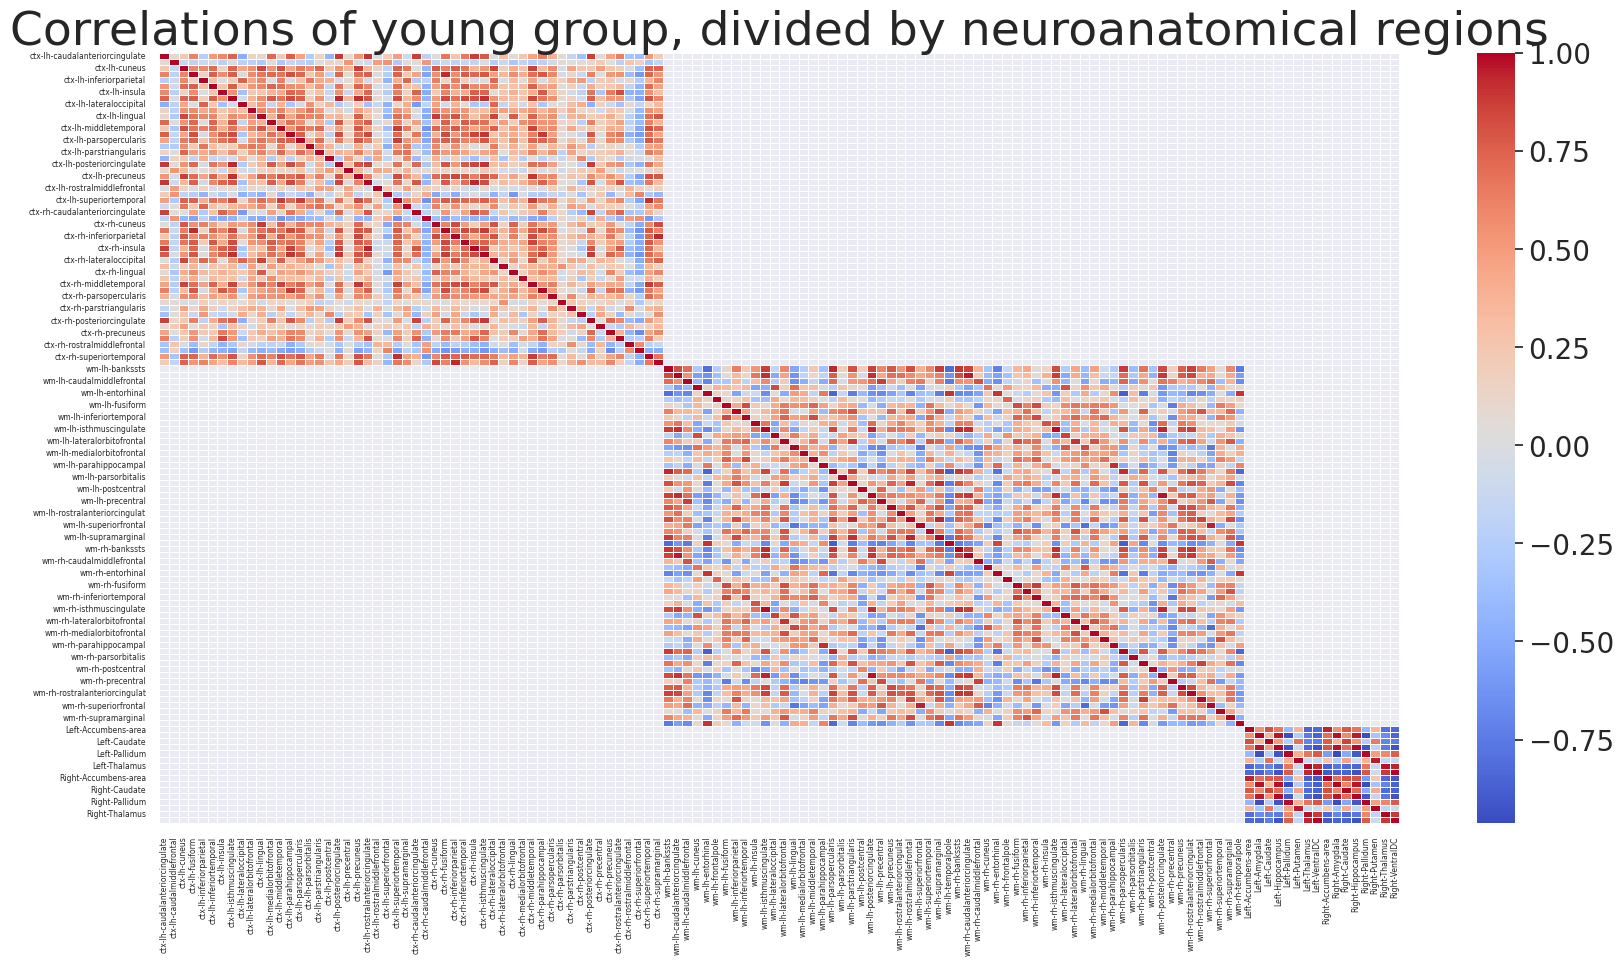

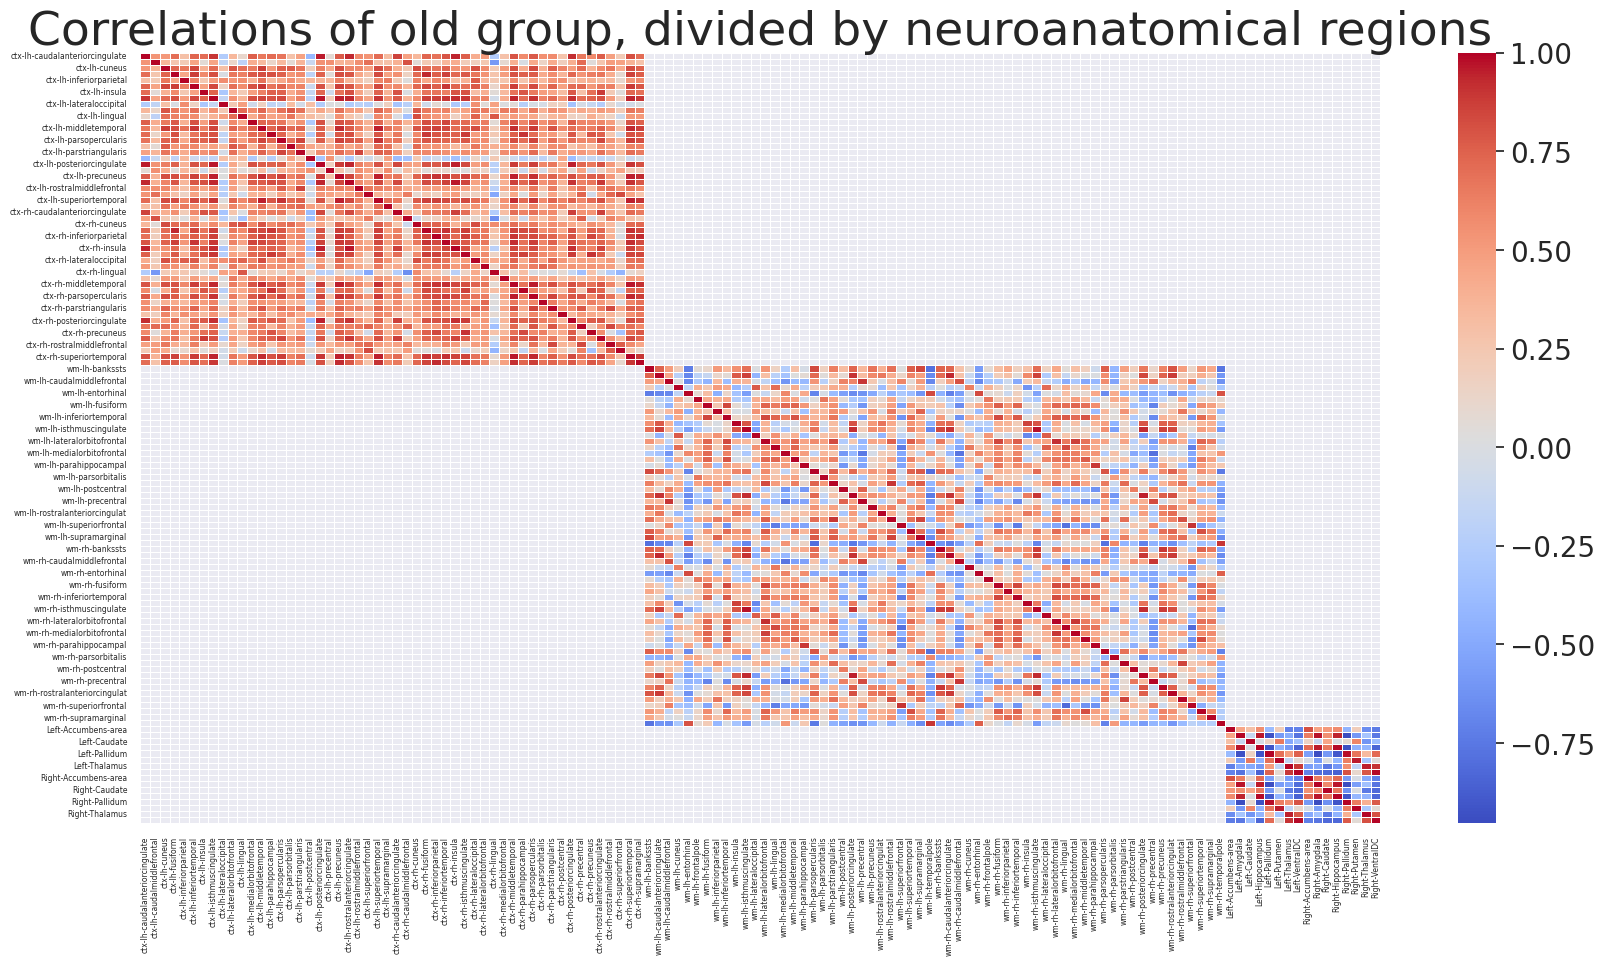

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



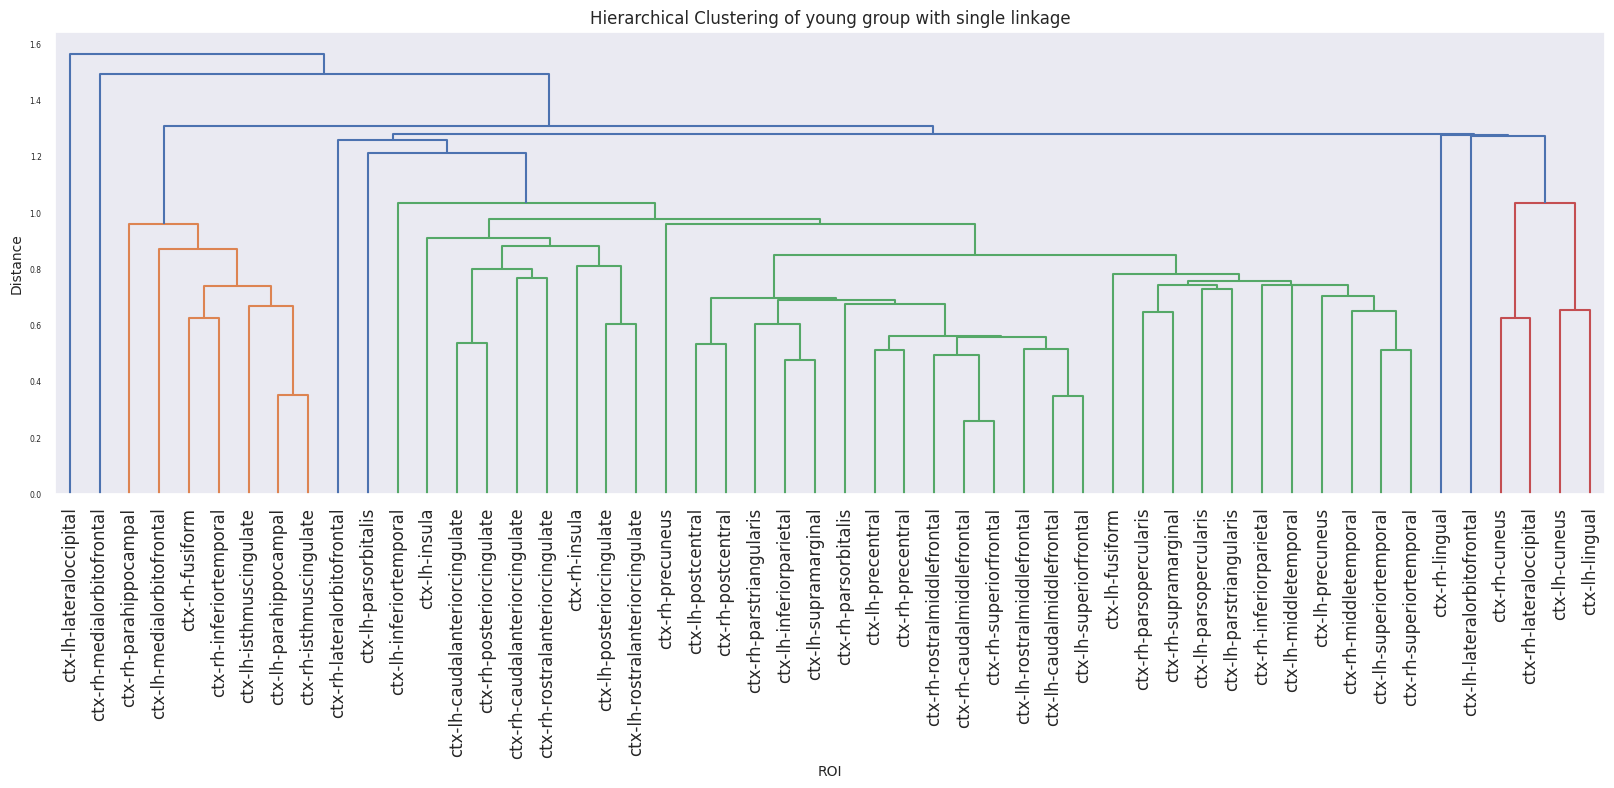

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



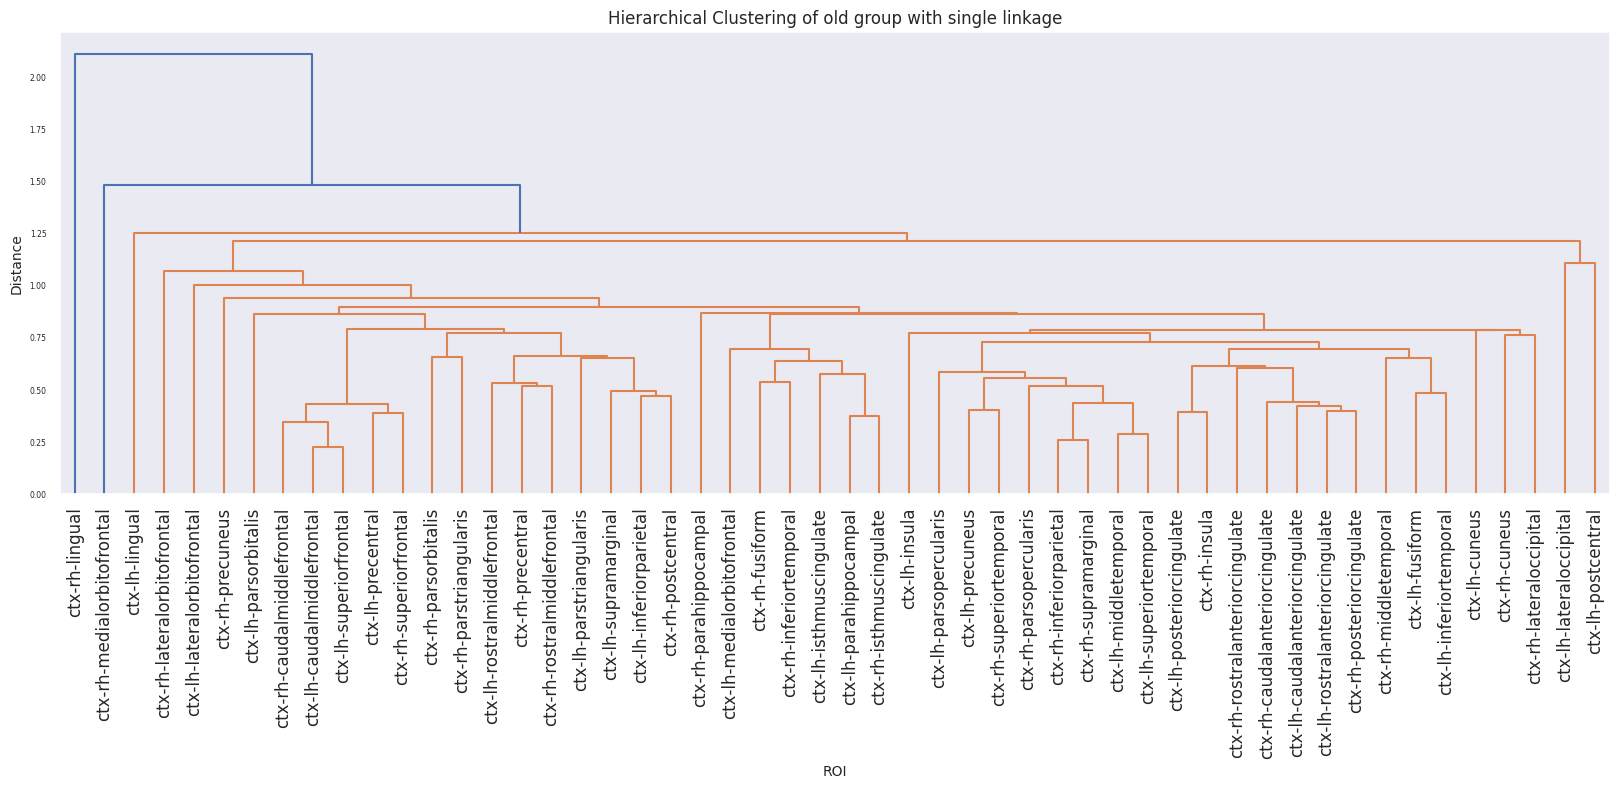

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



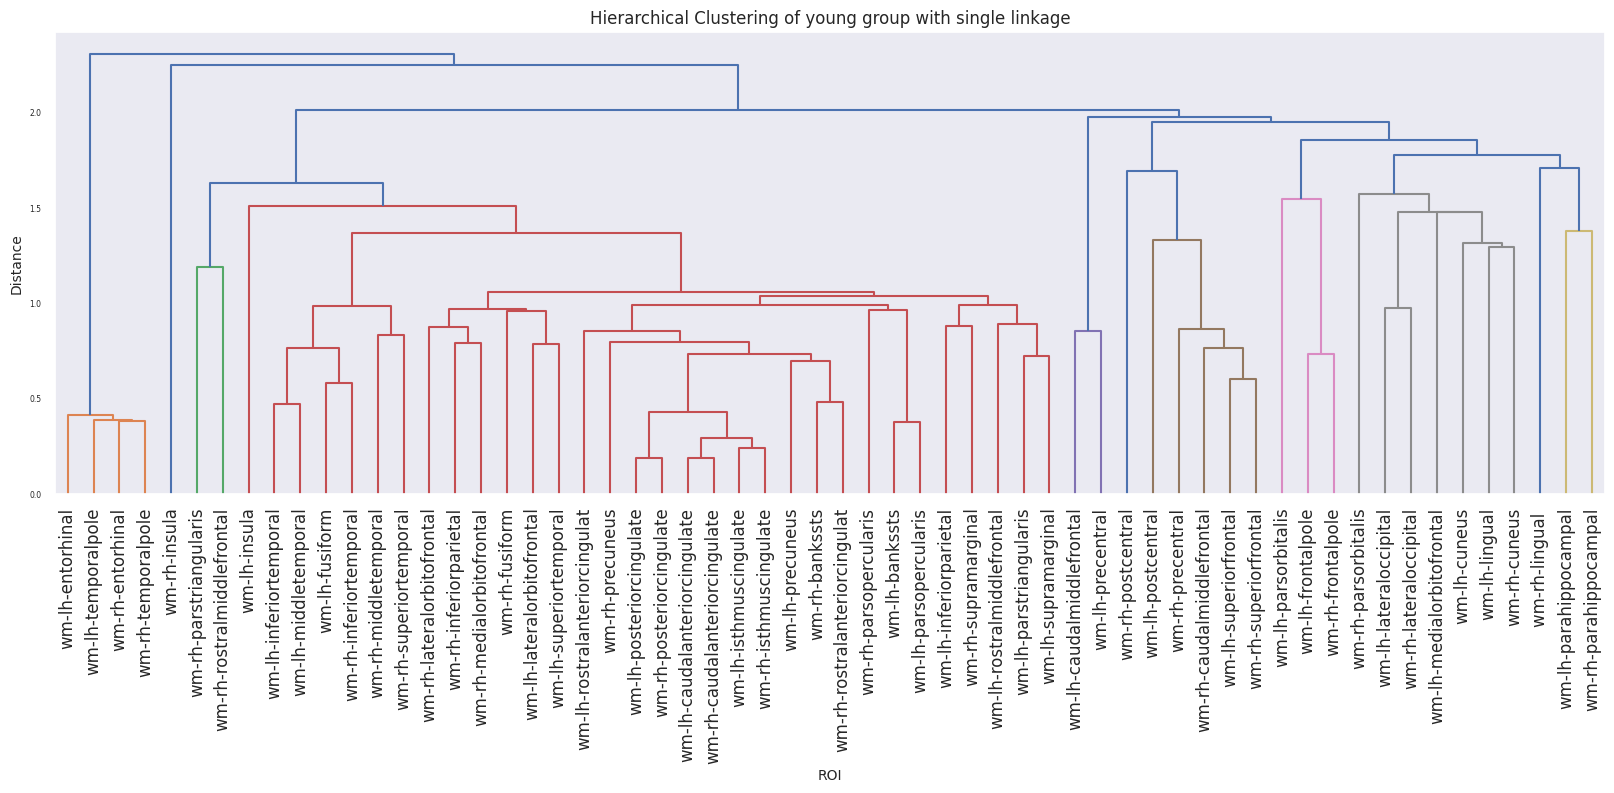

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



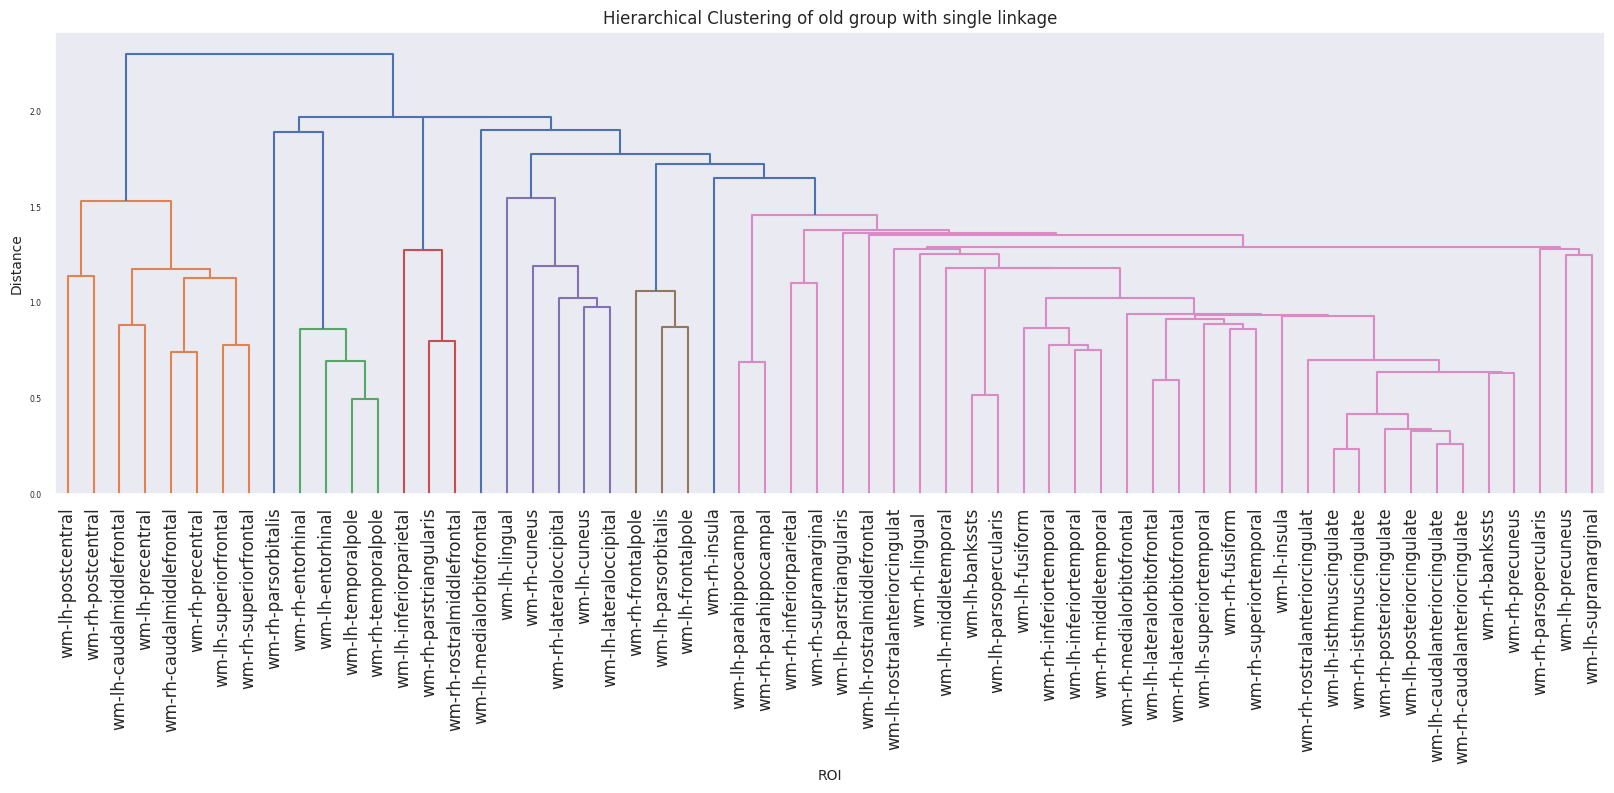

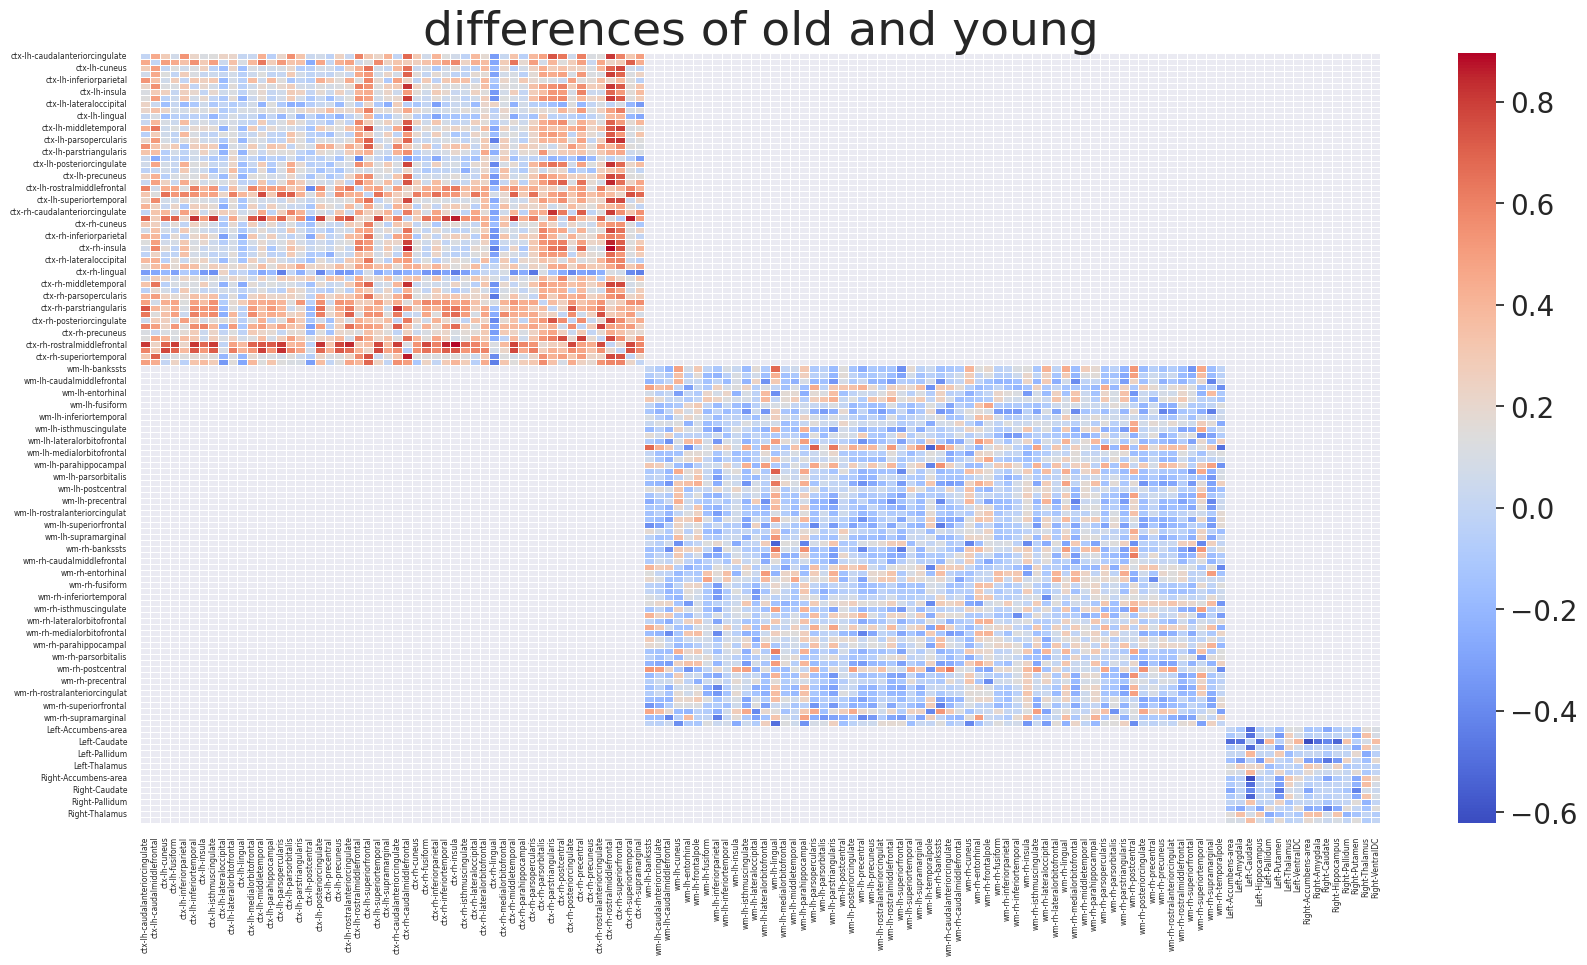

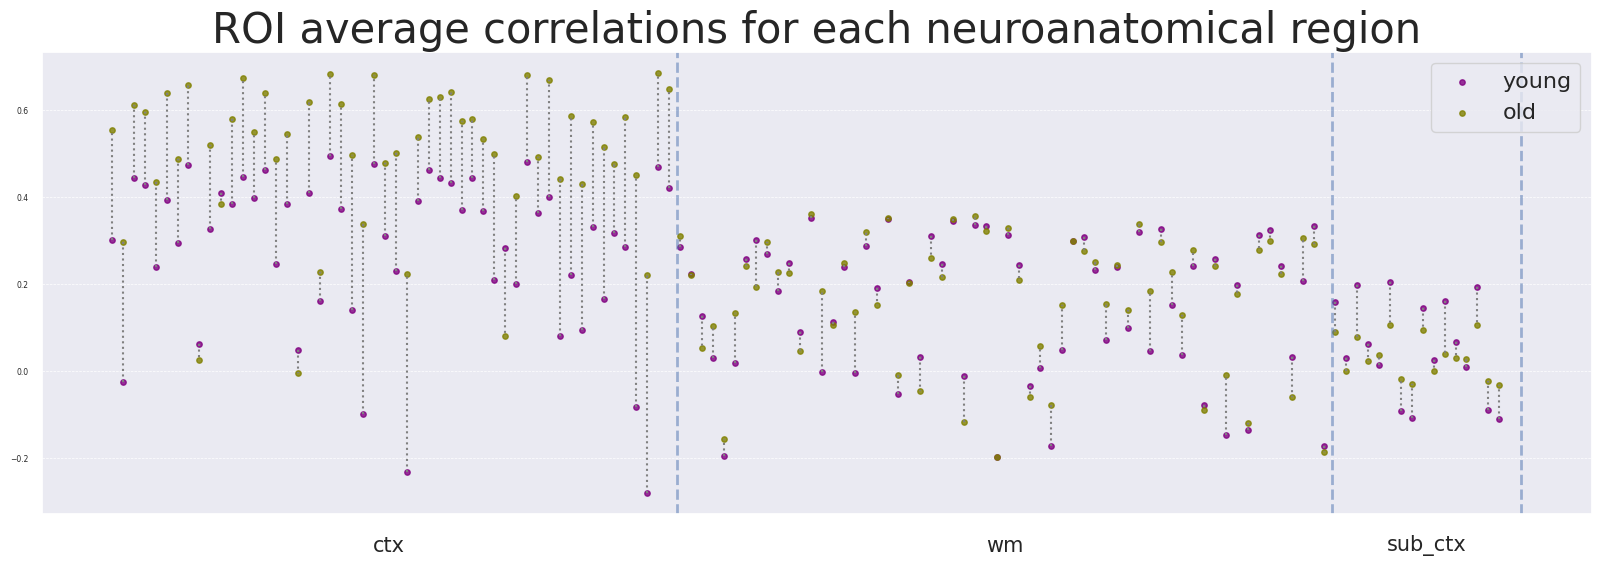

In [17]:
young_clusters, old_clusters = show_correlations_stats(chosen_data_z_score, young_data_z_score, old_data_z_score, 'pearson', divide=True, linkage_method='single')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



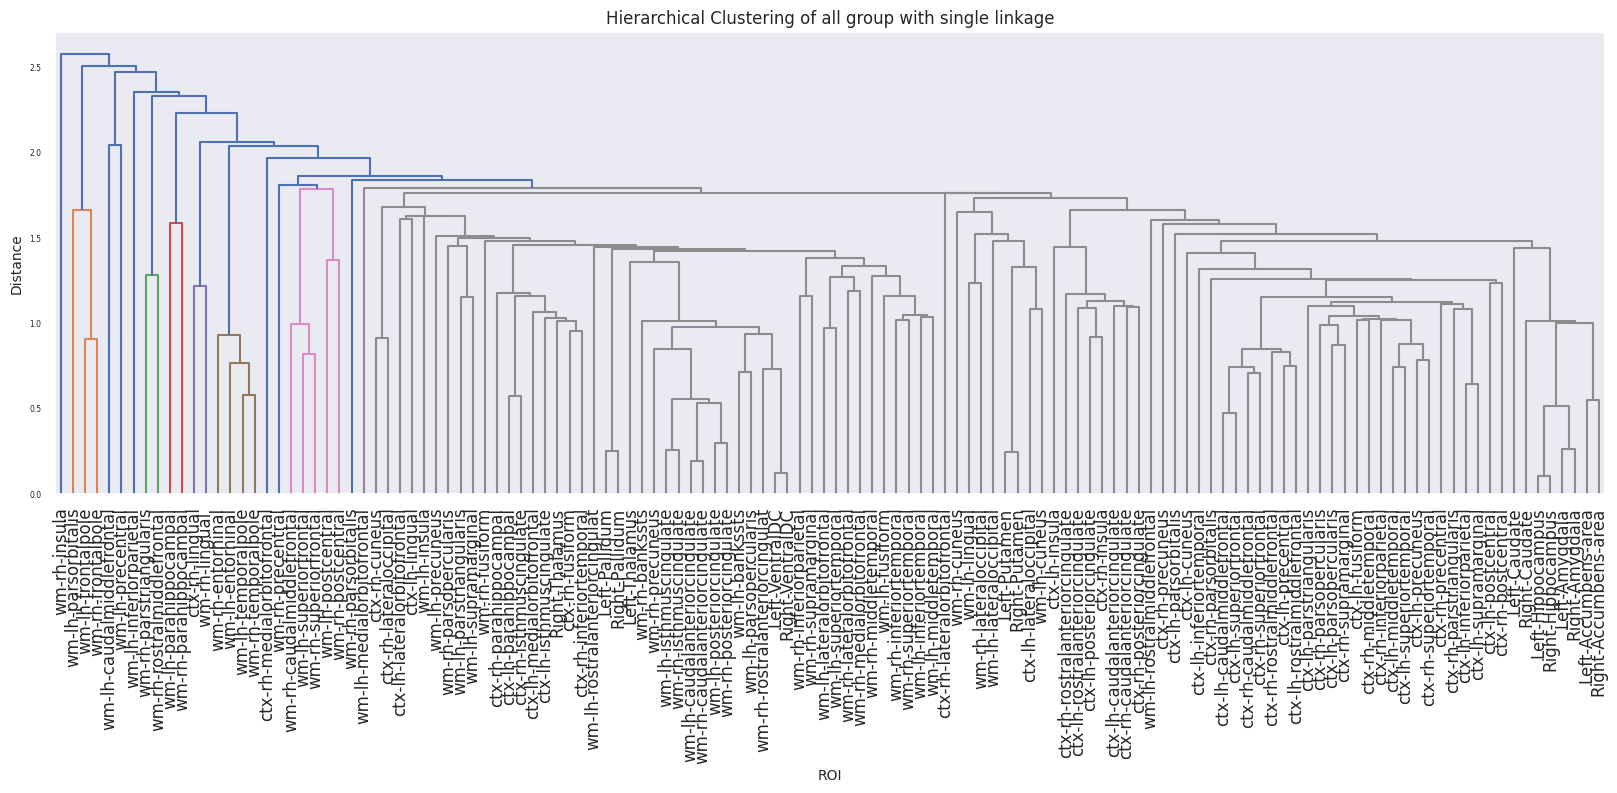

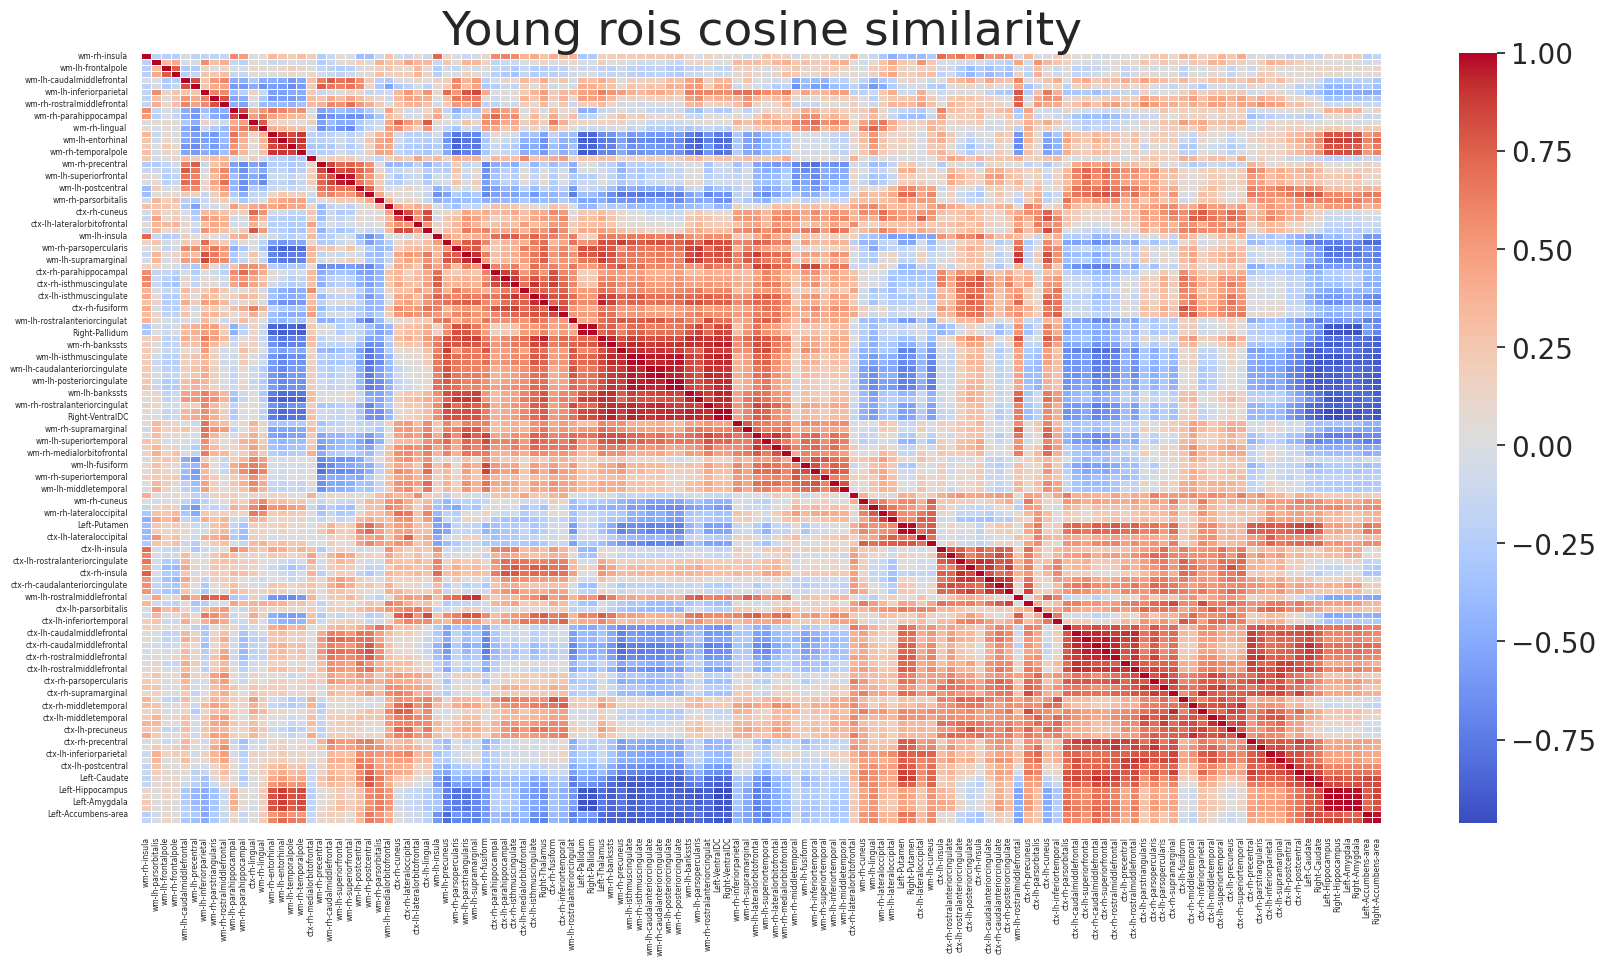

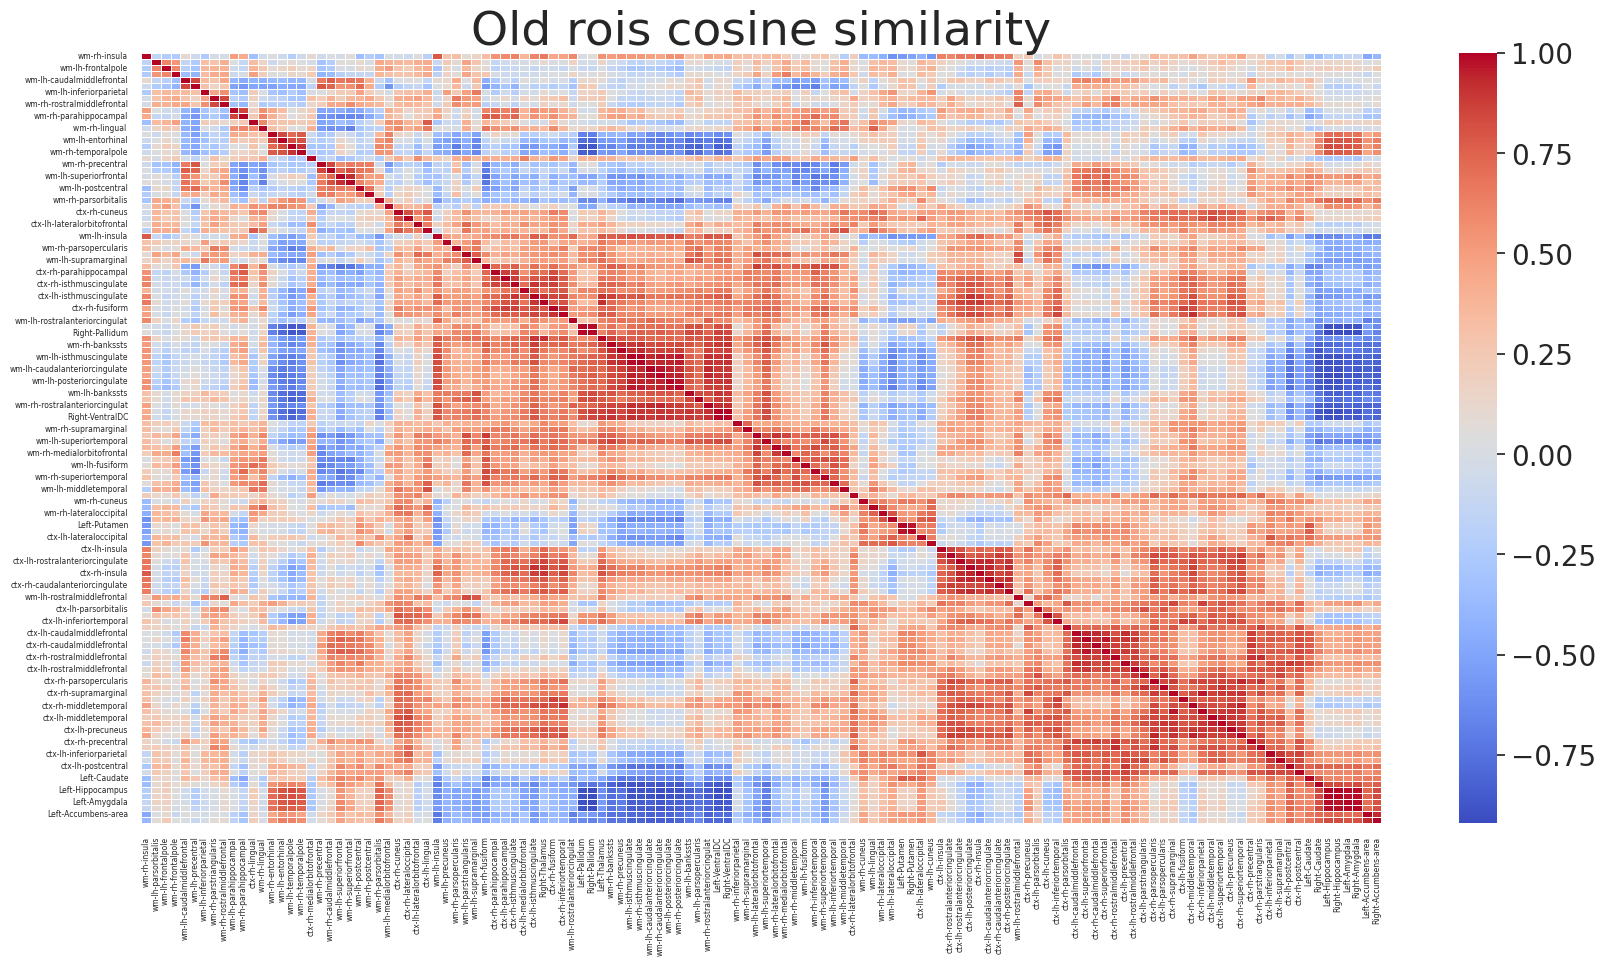

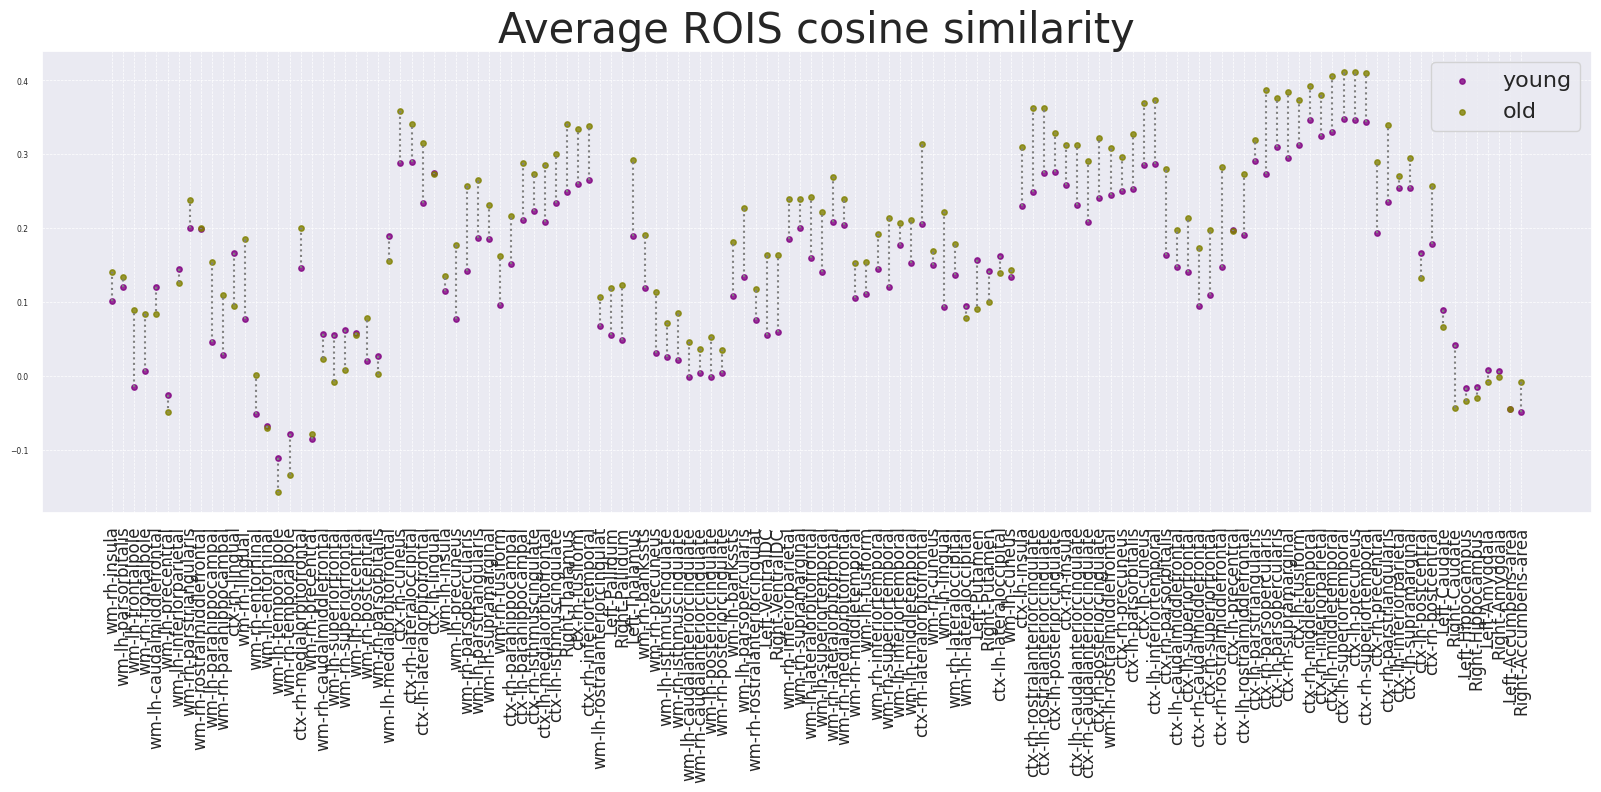

In [18]:
show_distances(cosine_similarity, params_to_work_with, chosen_data_z_score,
               young_data_z_score, old_data_z_score, 'cosine similarity')

Check t_test on the young and old groups

param r1 number of areas with significance differences: 60
param tv number of areas with significance differences: 34
param r2s number of areas with significance differences: 45
param mt number of areas with significance differences: 49
param t2 number of areas with significance differences: 65
param diffusion_fa number of areas with significance differences: 59
param diffusion_md number of areas with significance differences: 61


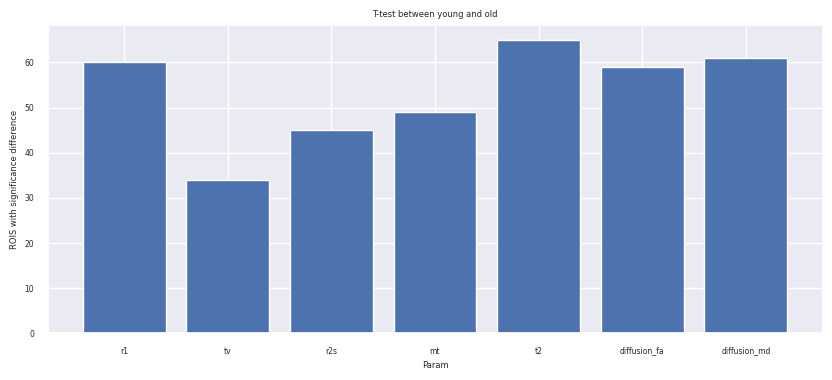

In [19]:
%autoreload 2
StatisticsWrapper.t_test_per_parameter_per_area(young_data_z_score, old_data_z_score, constants.ROI_ALL_BRAIN, 'ROI', params_to_work_with)

Subjects clustering 

In [20]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(
            data.drop(columns='label'))

    # Generate dynamic column names
    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    return reduced_data

In [21]:
young_features_df = pd.pivot_table(
    young_data_all_brain_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(
    old_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(
    chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

young_mask = young_features_df.index
old_mask = old_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[young_mask, 'label'] = 'young'
data_features_df.loc[old_mask, 'label'] = 'old'

In [22]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=36)

# data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

## Rois clustering

In [23]:
young_features_df = young_data_z_score.copy()
old_features_df = old_data_z_score.copy()


reduced_params = params_to_work_with + ['label']

# mean values
# young_features_df = young_features_df.groupby('ROI_name')[params_to_work_with].mean()
# old_features_df = old_features_df.groupby('ROI_name')[params_to_work_with].mean()

# Assign labels directly to DataFrame
young_features_df['label'] = 'young'
old_features_df['label'] = 'old'

all_features_df = pd.concat([young_features_df, old_features_df])

In [24]:

def plot_clusters_of_rois(reduced_data, prev_data, prior_annot, search_col, title):
    colors = sns.color_palette("husl", len(prior_annot.keys()))
    hue = []    
    for roi in prev_data[search_col]:
        for key, values in prior_annot.items():
            if roi in values:
                hue.append(key)
                
    ax = sns.scatterplot(
        x="var_1", y="var_2",
        hue=hue,
        palette=colors,
        data=reduced_data,
        legend="full",
    ).set_title(title, fontsize=12)

    plt.legend(fontsize='12')

In [25]:
model, model_name = TSNE(n_components=2, perplexity=100, random_state=0), 'T-SNE'
# model, model_name = PCA(n_components=2), 'PCA'
all_df_reduced = reduce_dim(model, all_features_df[reduced_params])

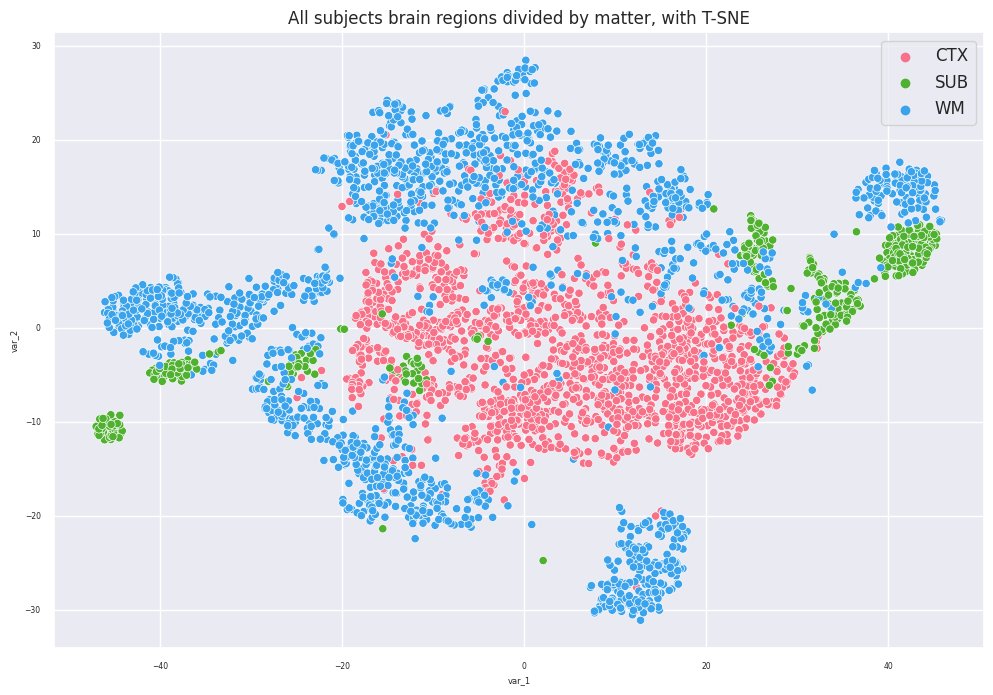

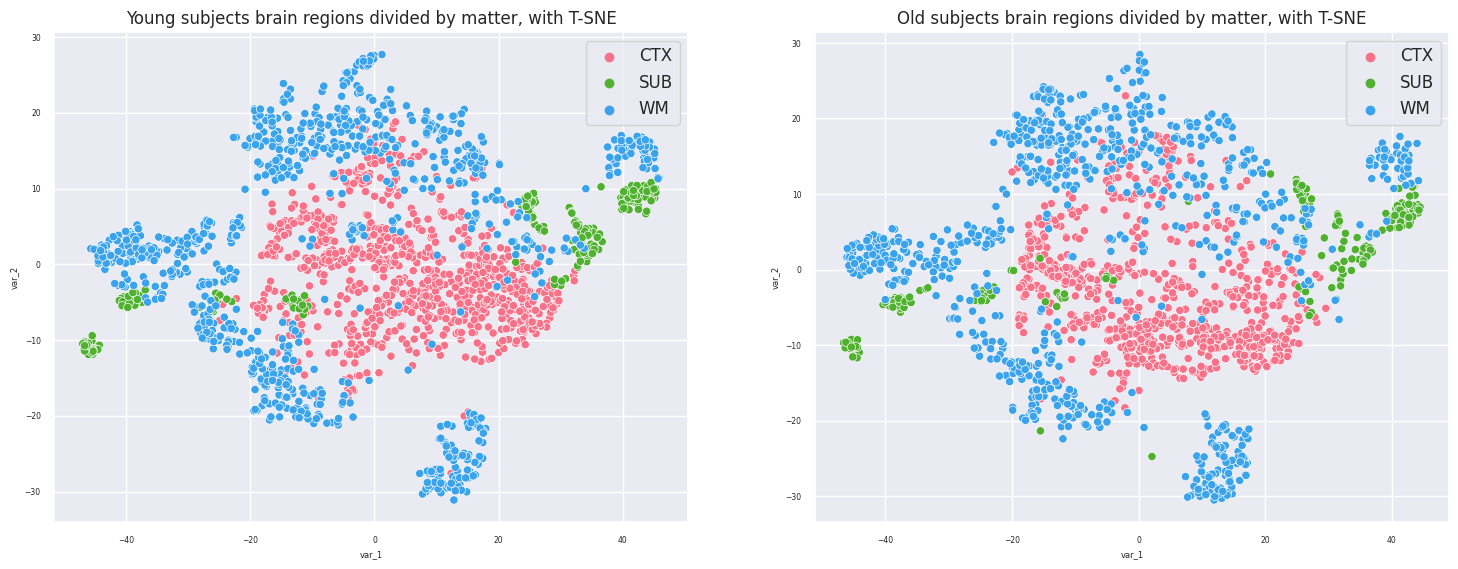

In [26]:
sub_matter = {
    "CTX": constants.ROI_CORTEX.values(),
    "WM": constants.ROI_WM.values(),
    "SUB": constants.ROI_SUBCORTEX.values()
}
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced, all_features_df, sub_matter,
                      'ROI_name',
                      title=f"All subjects brain regions divided by matter, with {model_name}")

plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'young'],
                      young_features_df,
                      sub_matter, 'ROI_name',
                      title=f"Young subjects brain regions divided by matter, with {model_name}")
plt.subplot(2, 2, 2)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'old'],
                      old_features_df,
                      sub_matter, 'ROI_name',
                      title=f"Old subjects brain regions divided by matter, with {model_name}")

In [27]:
all_features_df = all_features_df[all_features_df["ROI"].isin(constants.ROI_CORTEX.keys())]
model, model_name = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', metric='cosine'), 't-SNE'
# model, model_name = PCA(n_components=2), 'PCA'
all_df_reduced = reduce_dim(model, all_features_df[reduced_params])

# divide to hemi
all_features_df_lh_ix = all_features_df[all_features_df['ROI_name'].str.startswith('ctx-lh')].index
all_features_df_rh_ix = all_features_df[all_features_df['ROI_name'].str.startswith('ctx-rh')].index

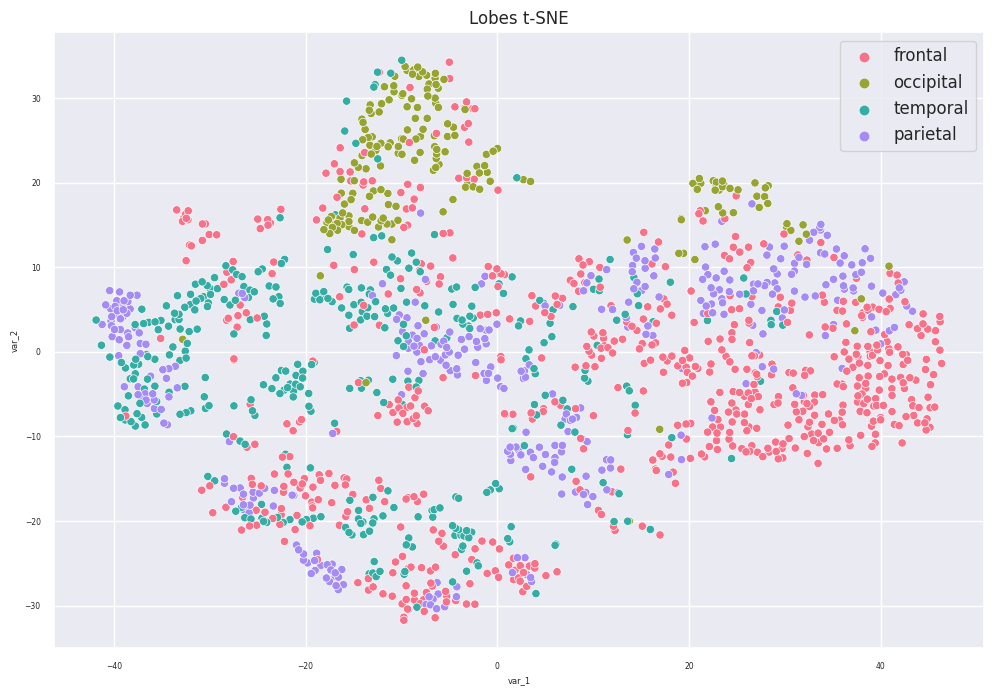

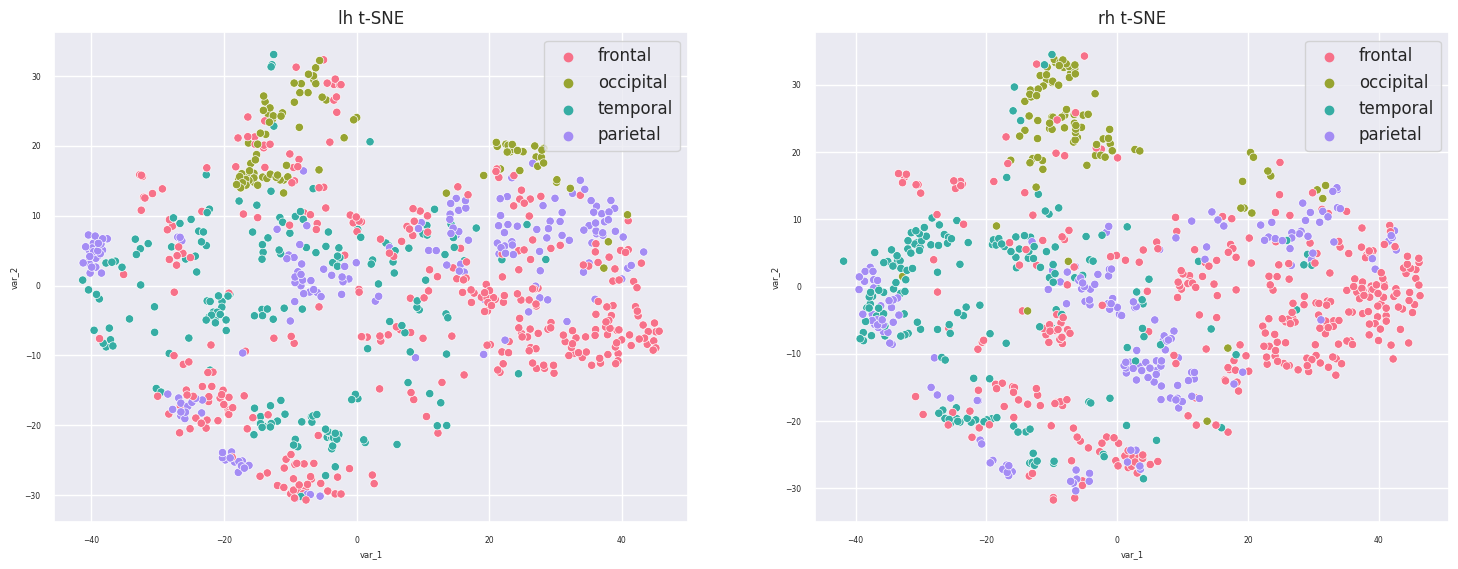

In [28]:
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced,
                      all_features_df,
                      constants.LOBES, 'ROI_name',
                      title=f"Lobes {model_name}")

plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)
plot_clusters_of_rois(all_df_reduced.loc[all_features_df_lh_ix],
                      all_features_df.loc[all_features_df_lh_ix],
                      constants.LOBES, 'ROI_name',
                      title=f"lh {model_name}")
plt.subplot(2, 2, 2)
plot_clusters_of_rois(all_df_reduced.loc[all_features_df_rh_ix],
                      all_features_df.loc[all_features_df_rh_ix],
                      constants.LOBES, 'ROI_name',
                      title=f"rh {model_name}")

# raw data

In [29]:
subjects_z_data = DataProcessor(
    constants.PATH_TO_CORTEX_all_params_z_score, constants.ROI_CORTEX, constants.ROI_CORTEX).get_data_proccessed()

subjects_z_data = StatisticsWrapper.chose_relevant_data(
    subjects_z_data, constants.ROI_CORTEX, params_to_work_with, params_to_work_with)

subjects_z_data = subjects_z_data.drop(columns=constants.SLOPES)

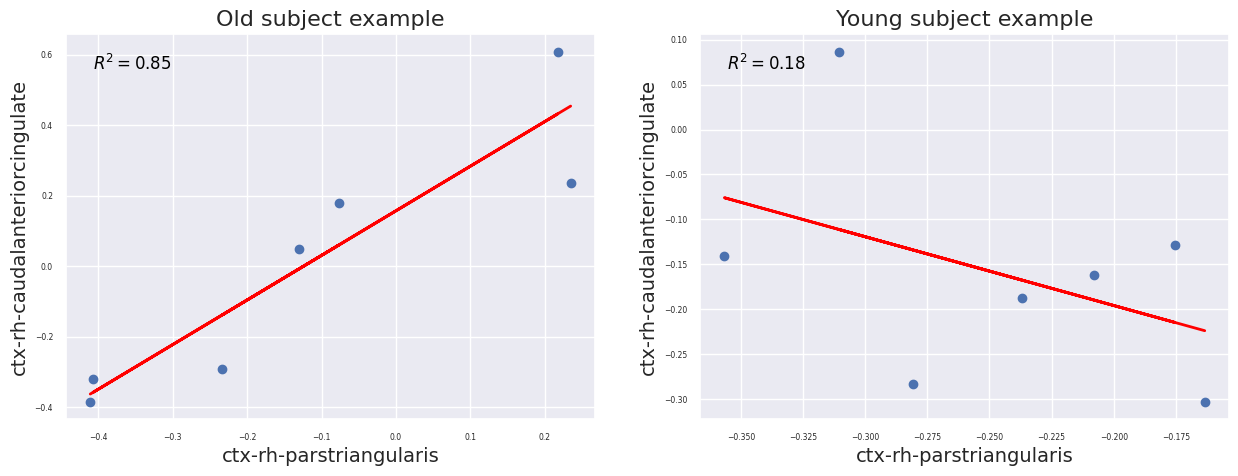

In [32]:
def check_linear_relation(data, roi1, roi2, params, ax, title):
    # Extract and reshape x and y
    x = data[data['ROI_name'] == roi1][params].values.reshape(-1, 1)  # Reshape to (n_samples, 1)
    y = data[data['ROI_name'] == roi2][params].values.reshape(-1)  # Reshape to (n_samples,)
    
    # Linear Regression
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    
    # Scatter plot and regression line
    ax.scatter(x, y)
    ax.set_xlabel(roi1, fontsize=14)
    ax.set_ylabel(roi2, fontsize=14)
    ax.plot(x, y_pred, color='red', linewidth=2)
    ax.set_title(title, fontsize=16)
    
    # Calculate and add R^2 value to the plot
    r2 = r2_score(y, y_pred)
    ax.text(0.05, 0.95, f'$R^2 = {r2:.2f}$', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', color='black')


roi1, roi2 = 'ctx-rh-parstriangularis', 'ctx-rh-caudalanteriorcingulate'

old_test = chosen_data_z_score[chosen_data_z_score['subjects'] == 'H019_AF']
young_test = chosen_data_z_score[chosen_data_z_score['subjects'] == 'H021_DH']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
check_linear_relation(old_test, roi1, roi2, params_to_work_with, ax[0], 'Old subject example')
check_linear_relation(young_test, roi1, roi2, params_to_work_with, ax[1], 'Young subject example')
